In [1]:
%load_ext autoreload
%autoreload 2

# External imports
import polars as pl
import matplotlib.pyplot as plt

# Local imports
from fart.constants import feature_names as fn, colors as co
from fart.features.calculate_technical_indicators import calculate_technical_indicators
from fart.features.generate_trade_signals import generate_trade_signals
from fart.features.parse_timestamp_to_datetime import parse_timestamp_to_datetime
from fart.utils.get_last_modified_data_file import get_last_modified_data_file
from fart.utils.trade_strategy import TradeStrategy
from fart.visualization.candlestick_chart import CandlestickChart

In [2]:
# Get the last modified data file
last_modified_data_file = get_last_modified_data_file("../data")

# Load data
df = pl.read_csv(last_modified_data_file)

In [3]:
# Convert timestamp to datetime
df = parse_timestamp_to_datetime(df)

In [4]:
# Calculate technical indicators:
# - Bollinger Bands
# - Exponential Moving Average,
# - Moving Average Convergence Divergence
# - Relative Strength Index
df = calculate_technical_indicators(df)

In [5]:
# Generate trading signals based on technical indicators
df = generate_trade_signals(df)

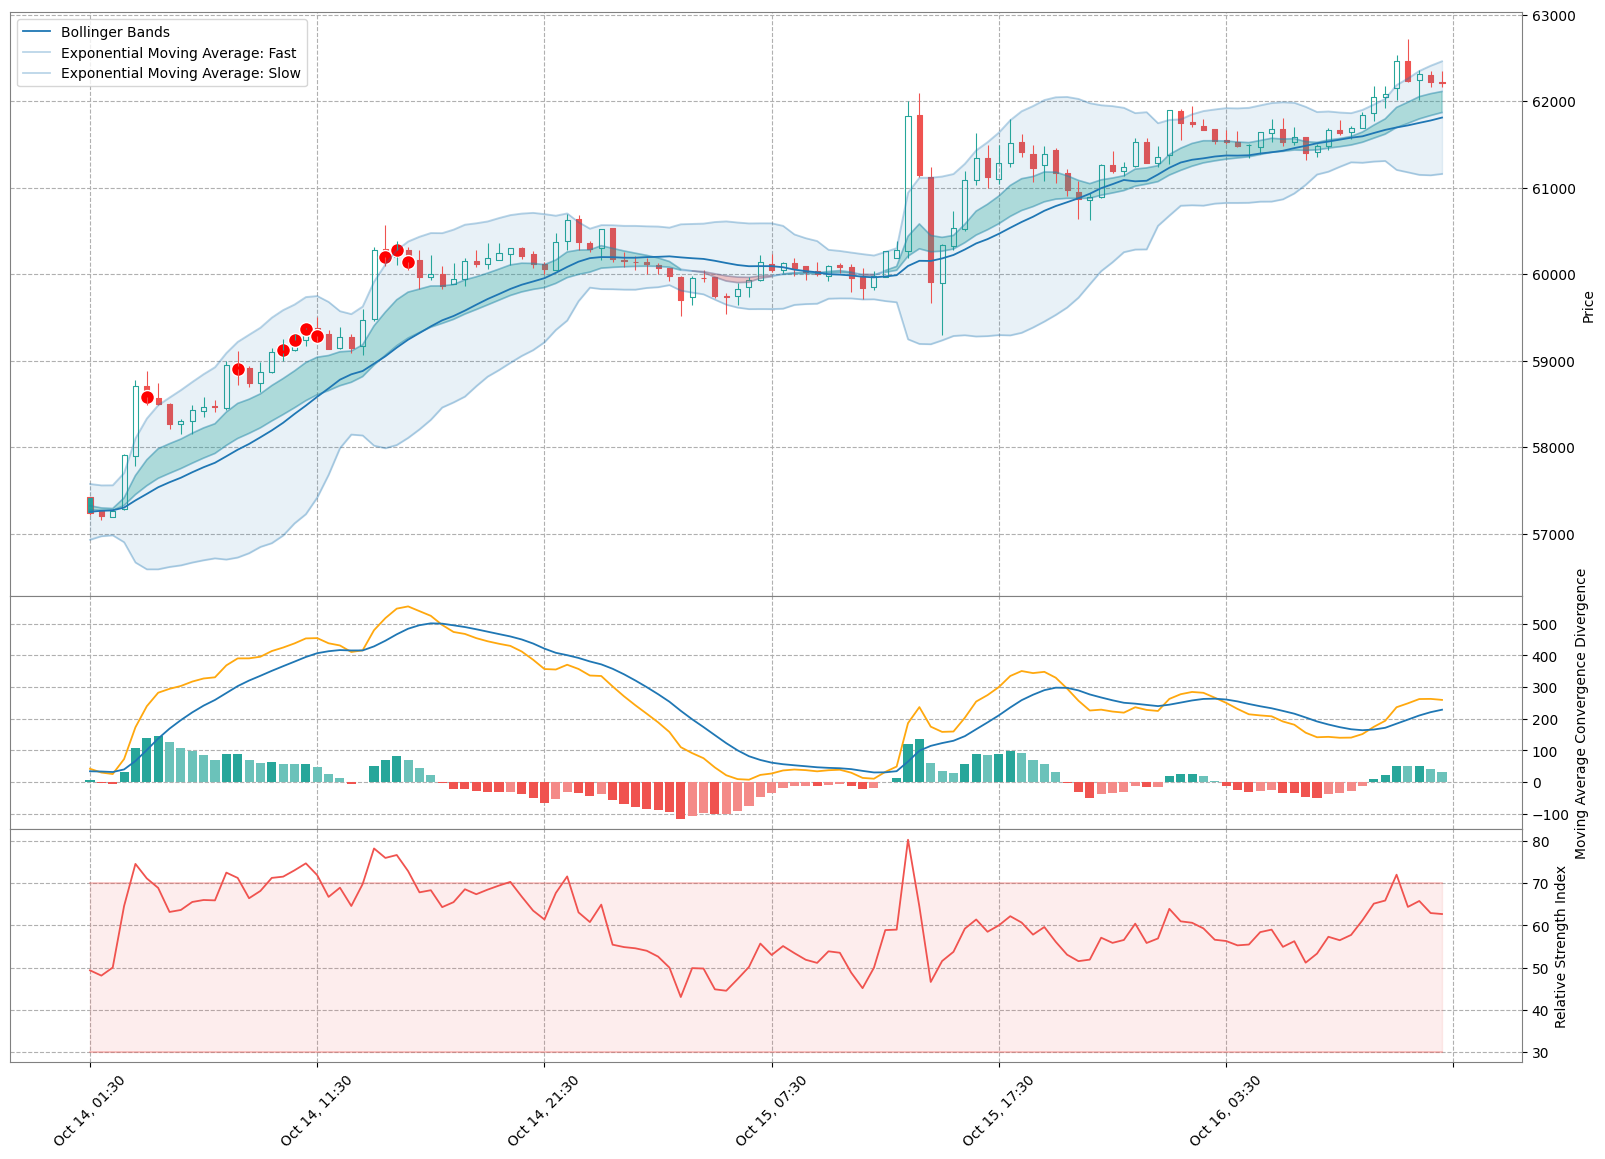

In [6]:
# Plot candlestick chart based on subset
candlestick_chart = CandlestickChart(df.to_pandas().set_index(fn.DATETIME))
candlestick_chart.plot()

In [7]:
# Backtest trade strategy
trade_strategy = TradeStrategy(df)
trade_strategy.backtest()

In [8]:
# Create pandas DataFrame from trade strategy trades list
trades = pl.DataFrame(
    trade_strategy.trades,
    orient="row",
    schema=[
        (fn.TIMESTAMP, pl.Int64),
        (fn.ACTION, pl.Int32),
        (fn.TRADE_PRICE, pl.Float64),
        (fn.SHARES, pl.Float64),
        (fn.PROCEEDS, pl.Float64),
    ],
)

In [9]:
# Caclulate profit/loss for each trade
sells = trades.filter(pl.col(fn.ACTION) == -1)
sells = sells.drop(fn.ACTION)

# Define series with index number of each sell
index = pl.Series(fn.INDEX, list(range(0, len(sells))))

# Define series with calculated profit/loss for each trade
profit_loss = pl.Series(
    fn.PROFIT_LOSS,
    (sells[fn.PROCEEDS] - sells[fn.PROCEEDS].shift()) / sells[fn.PROCEEDS] * 100,
)

# Add both series to sells DataFrame
sells = sells.with_columns(
    profit_loss,
    index,
)

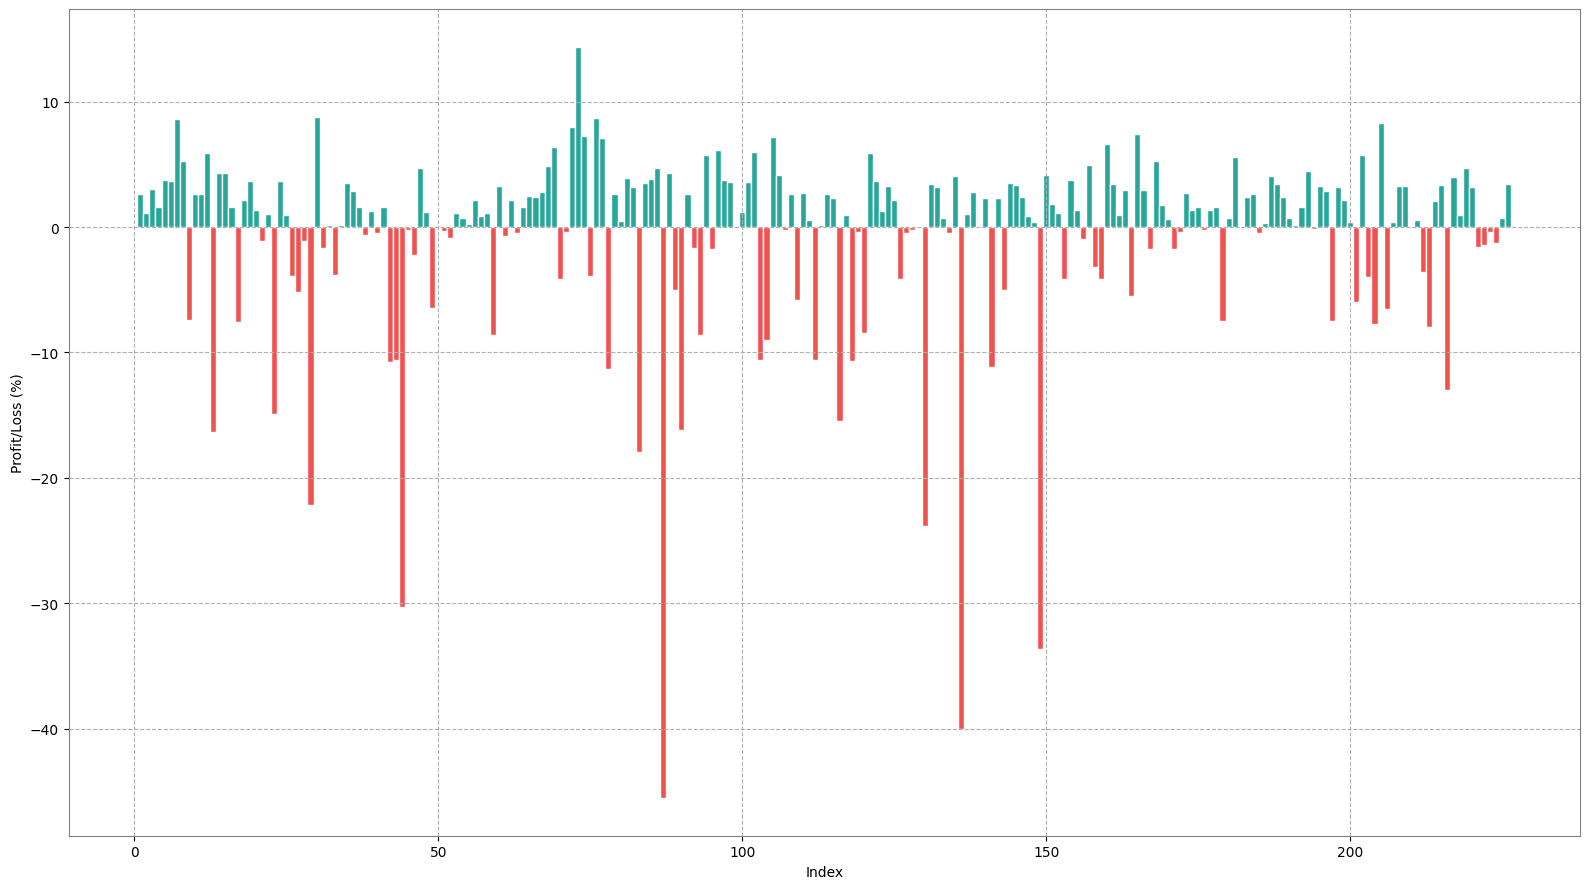

In [10]:
# Visualize profit/loss
columns = [
    fn.INDEX,
    fn.TIMESTAMP,
    fn.PROFIT_LOSS,
]

profit = sells.select(columns).filter(sells[fn.PROFIT_LOSS] >= 0)
loss = sells.select(columns).filter(sells[fn.PROFIT_LOSS] < 0)

fig, ax = plt.subplots(figsize=(16, 9))

bar_config = dict(
    edgecolor="white",
    width=1,
)

ax.bar(
    profit[fn.INDEX].to_numpy(),
    profit[fn.PROFIT_LOSS].to_numpy(),
    color=co.PERSIAN_GREEN_MAIN,
    **bar_config,
)

ax.bar(
    loss[fn.INDEX].to_numpy(),
    loss[fn.PROFIT_LOSS].to_numpy(),
    color=co.IMPERIAL_RED_MAIN,
    **bar_config,
)

ax.set_xlabel(fn.INDEX)
ax.set_ylabel(f"{fn.PROFIT_LOSS} (%)")

plt.tight_layout()
plt.show()

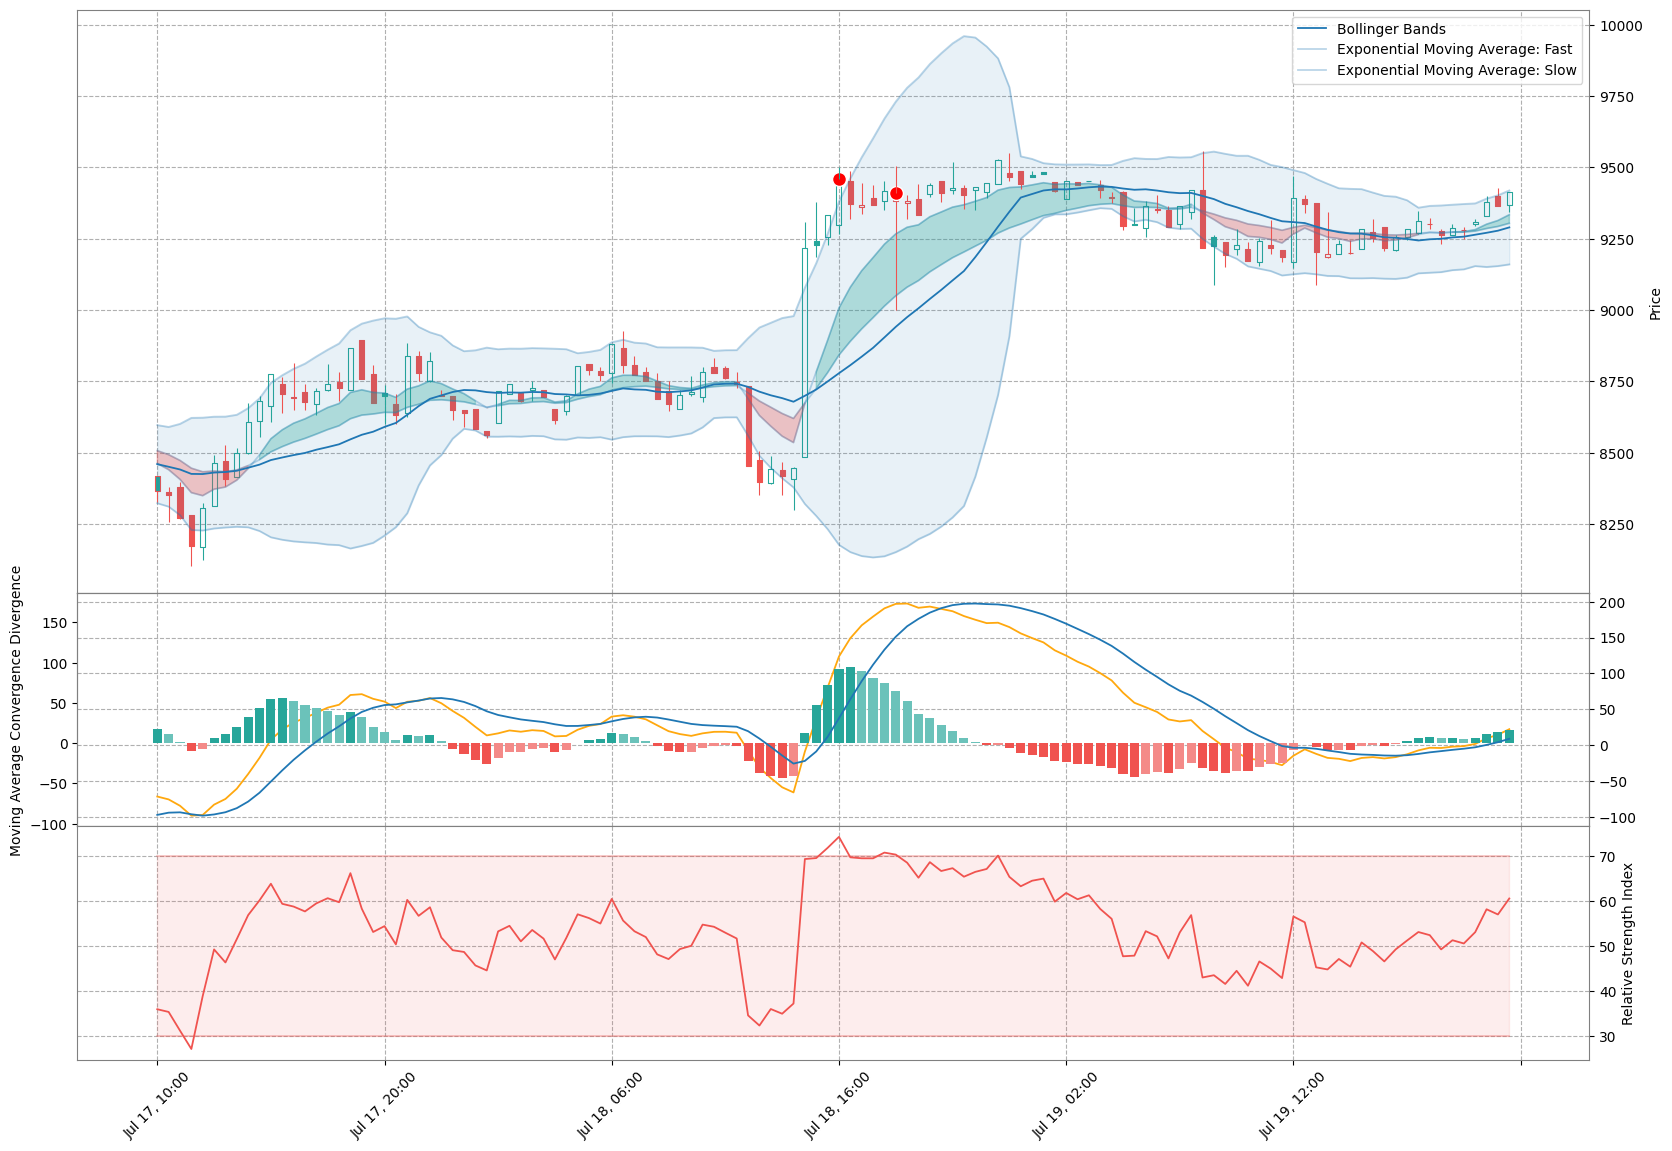

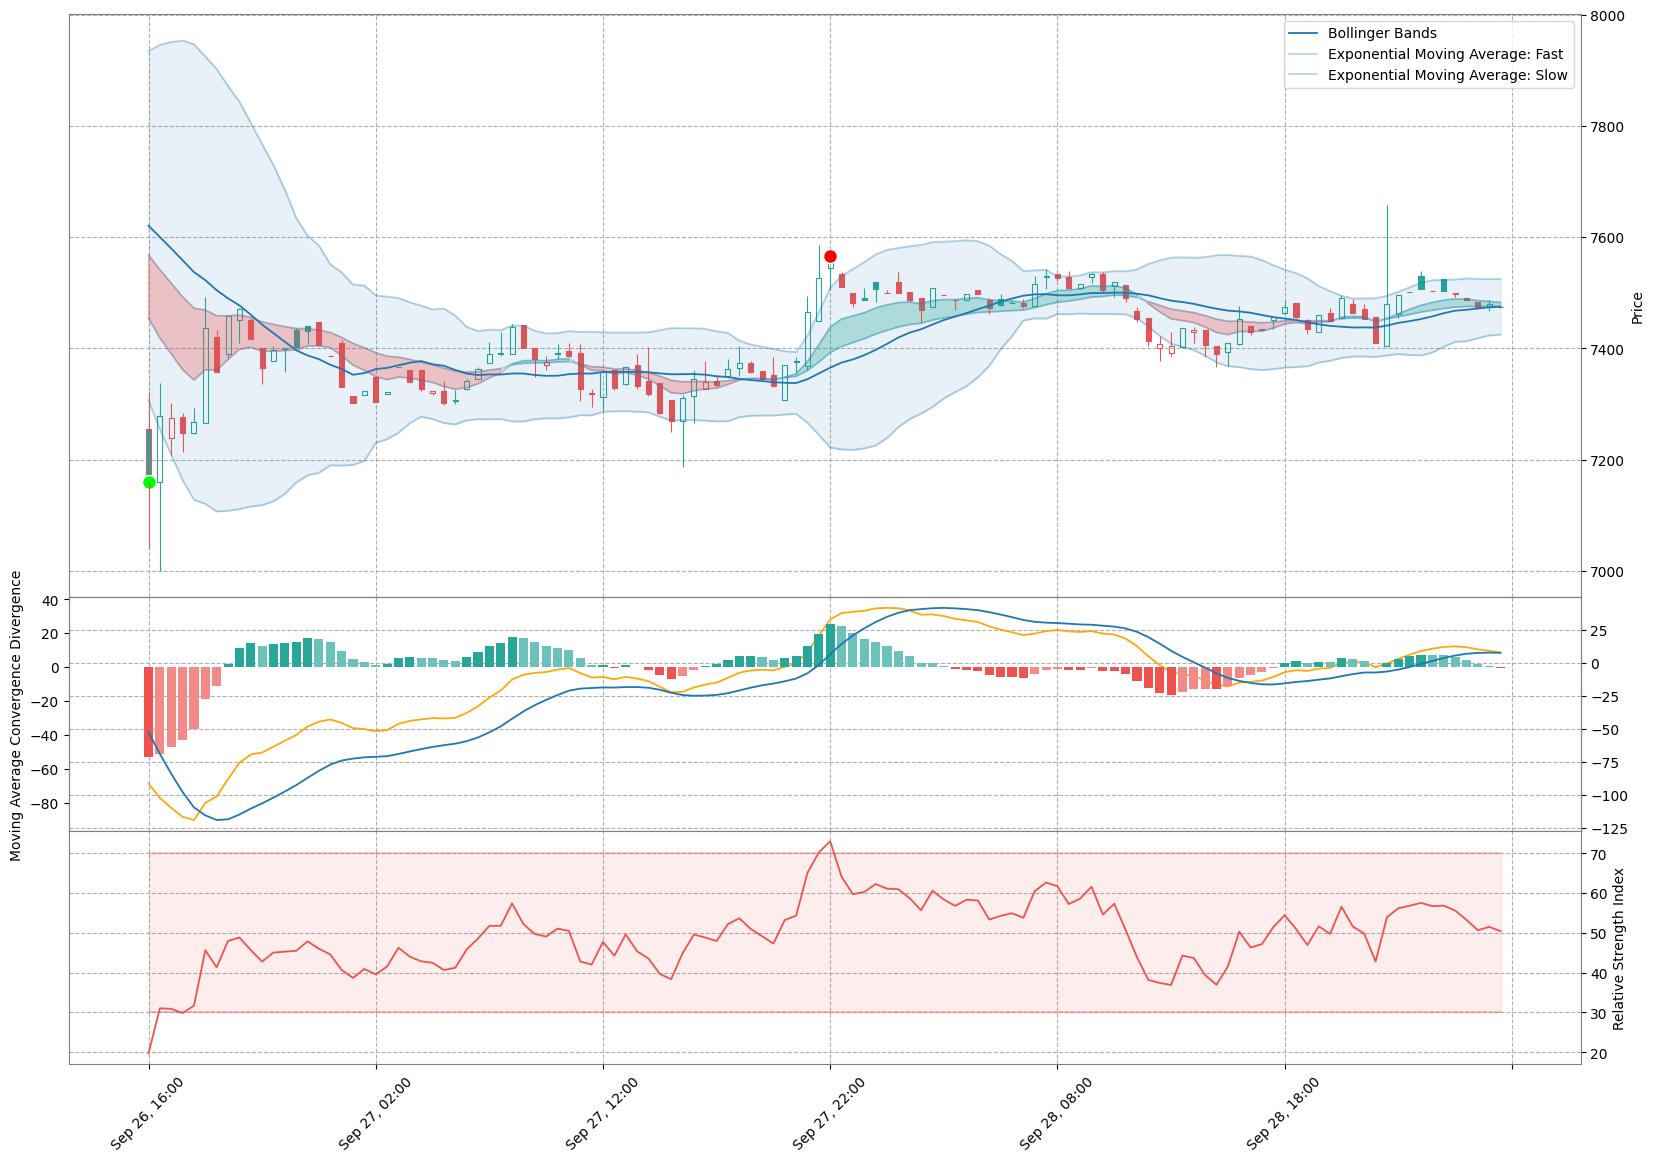

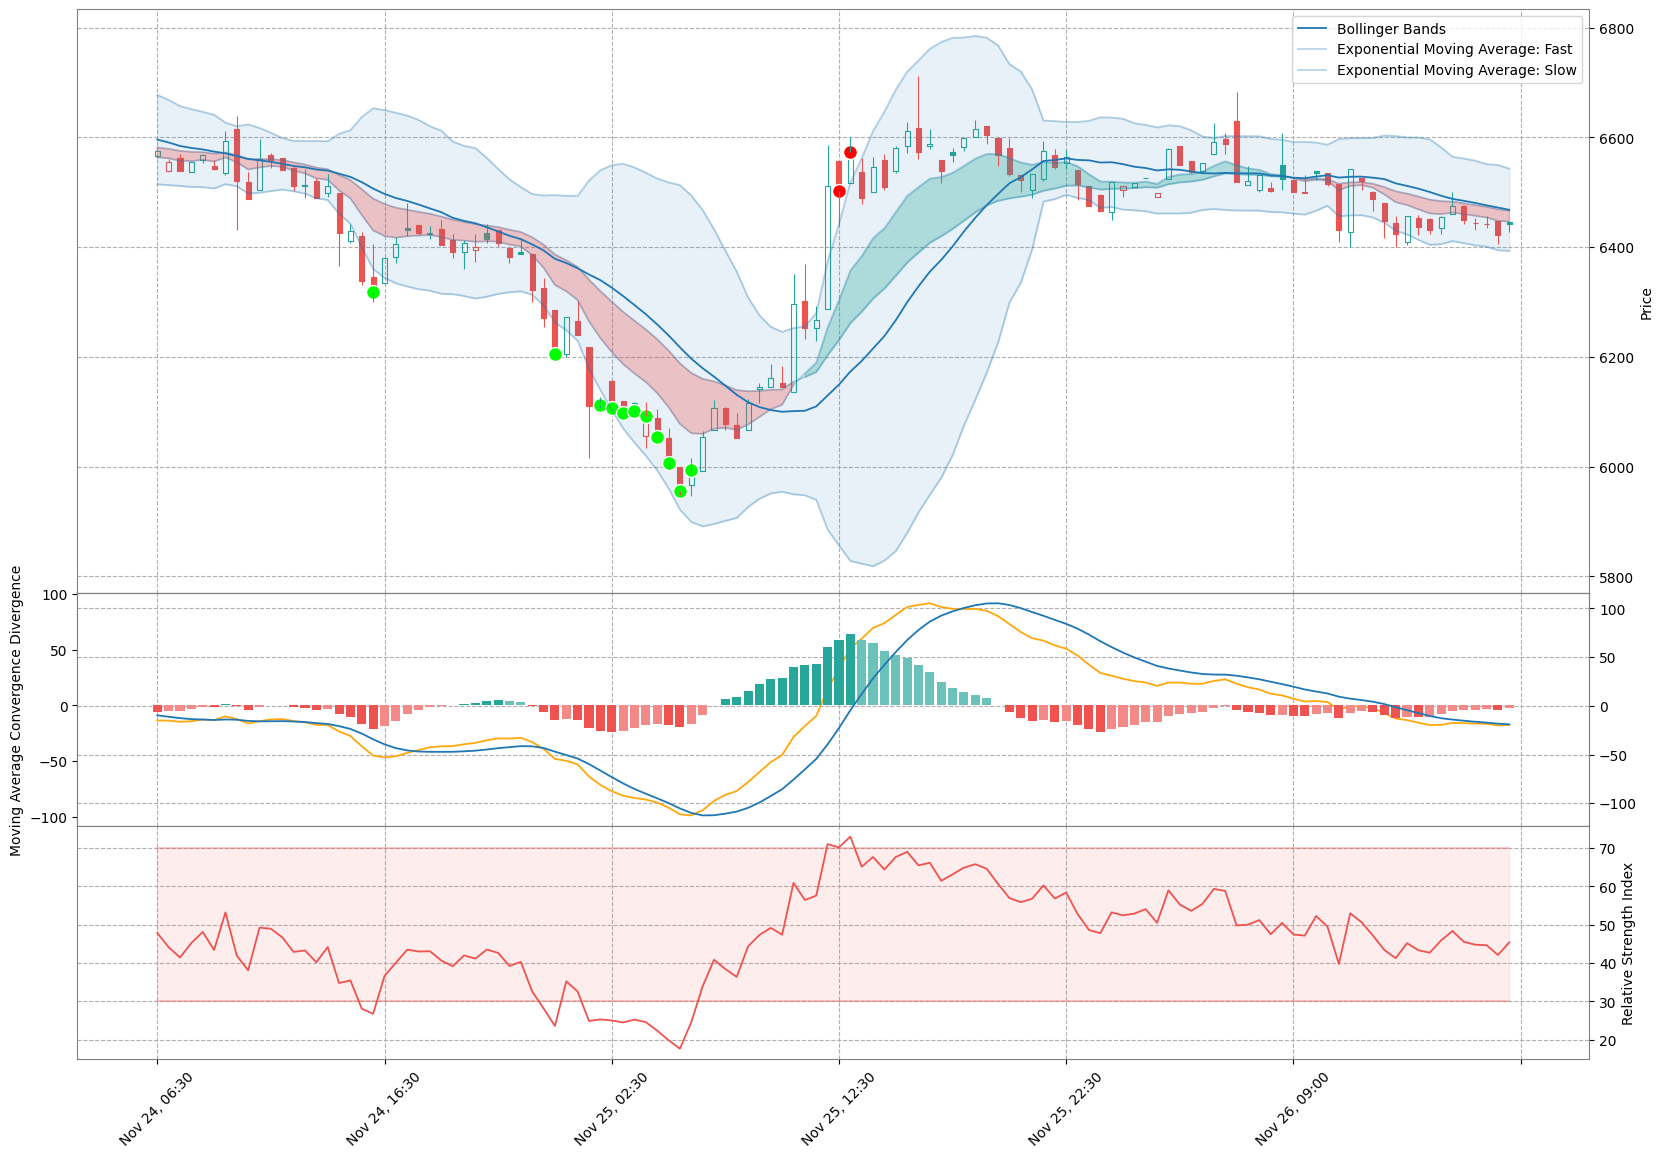

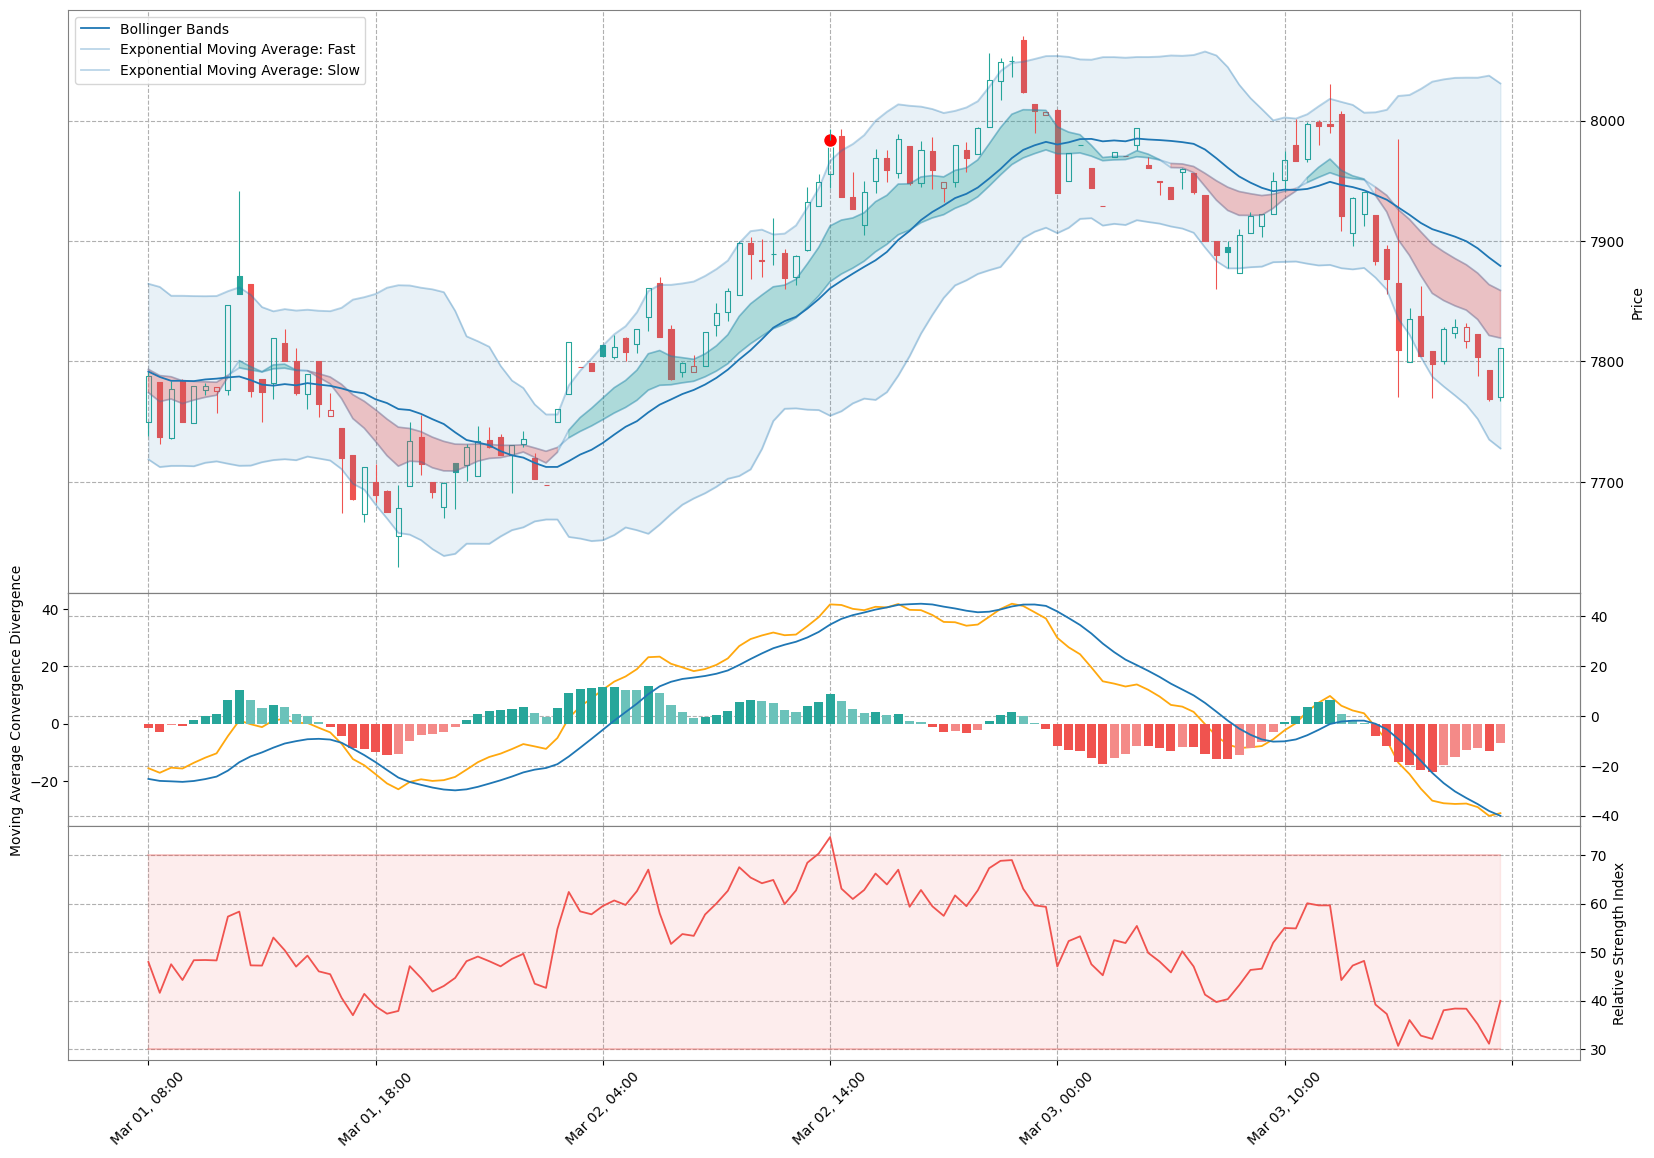

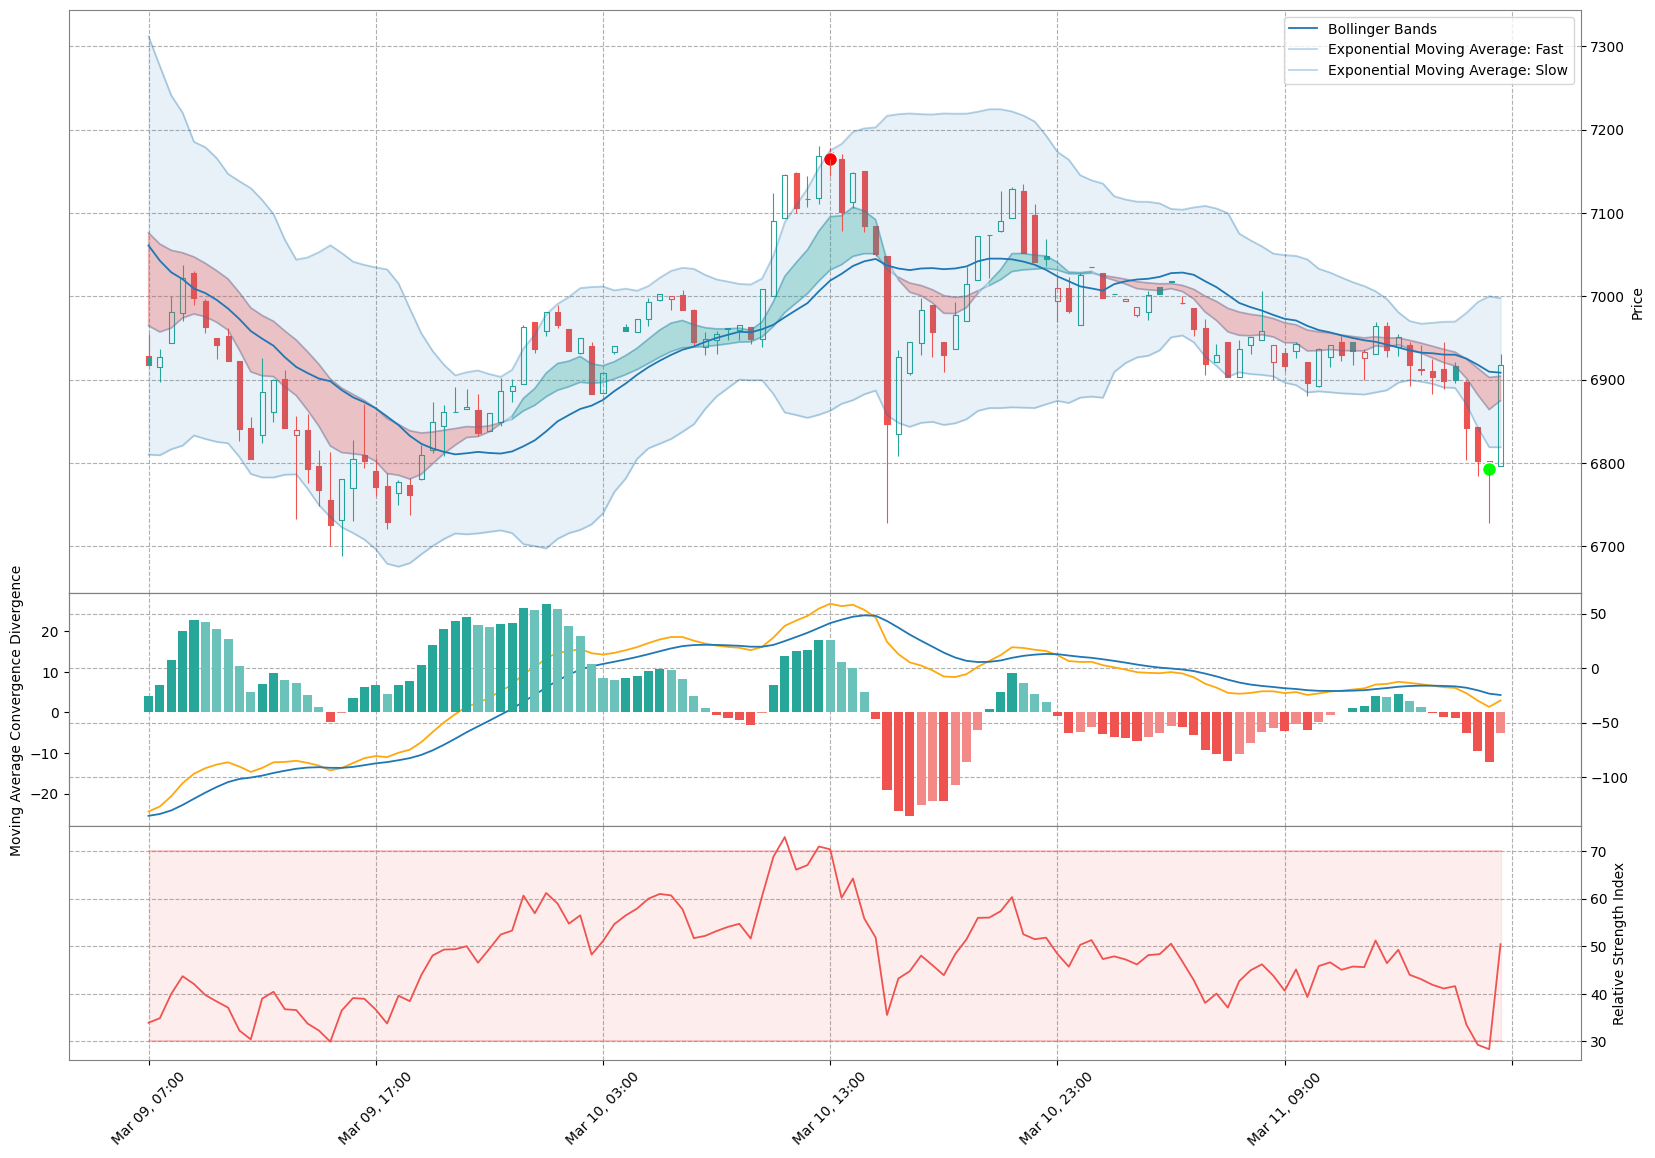

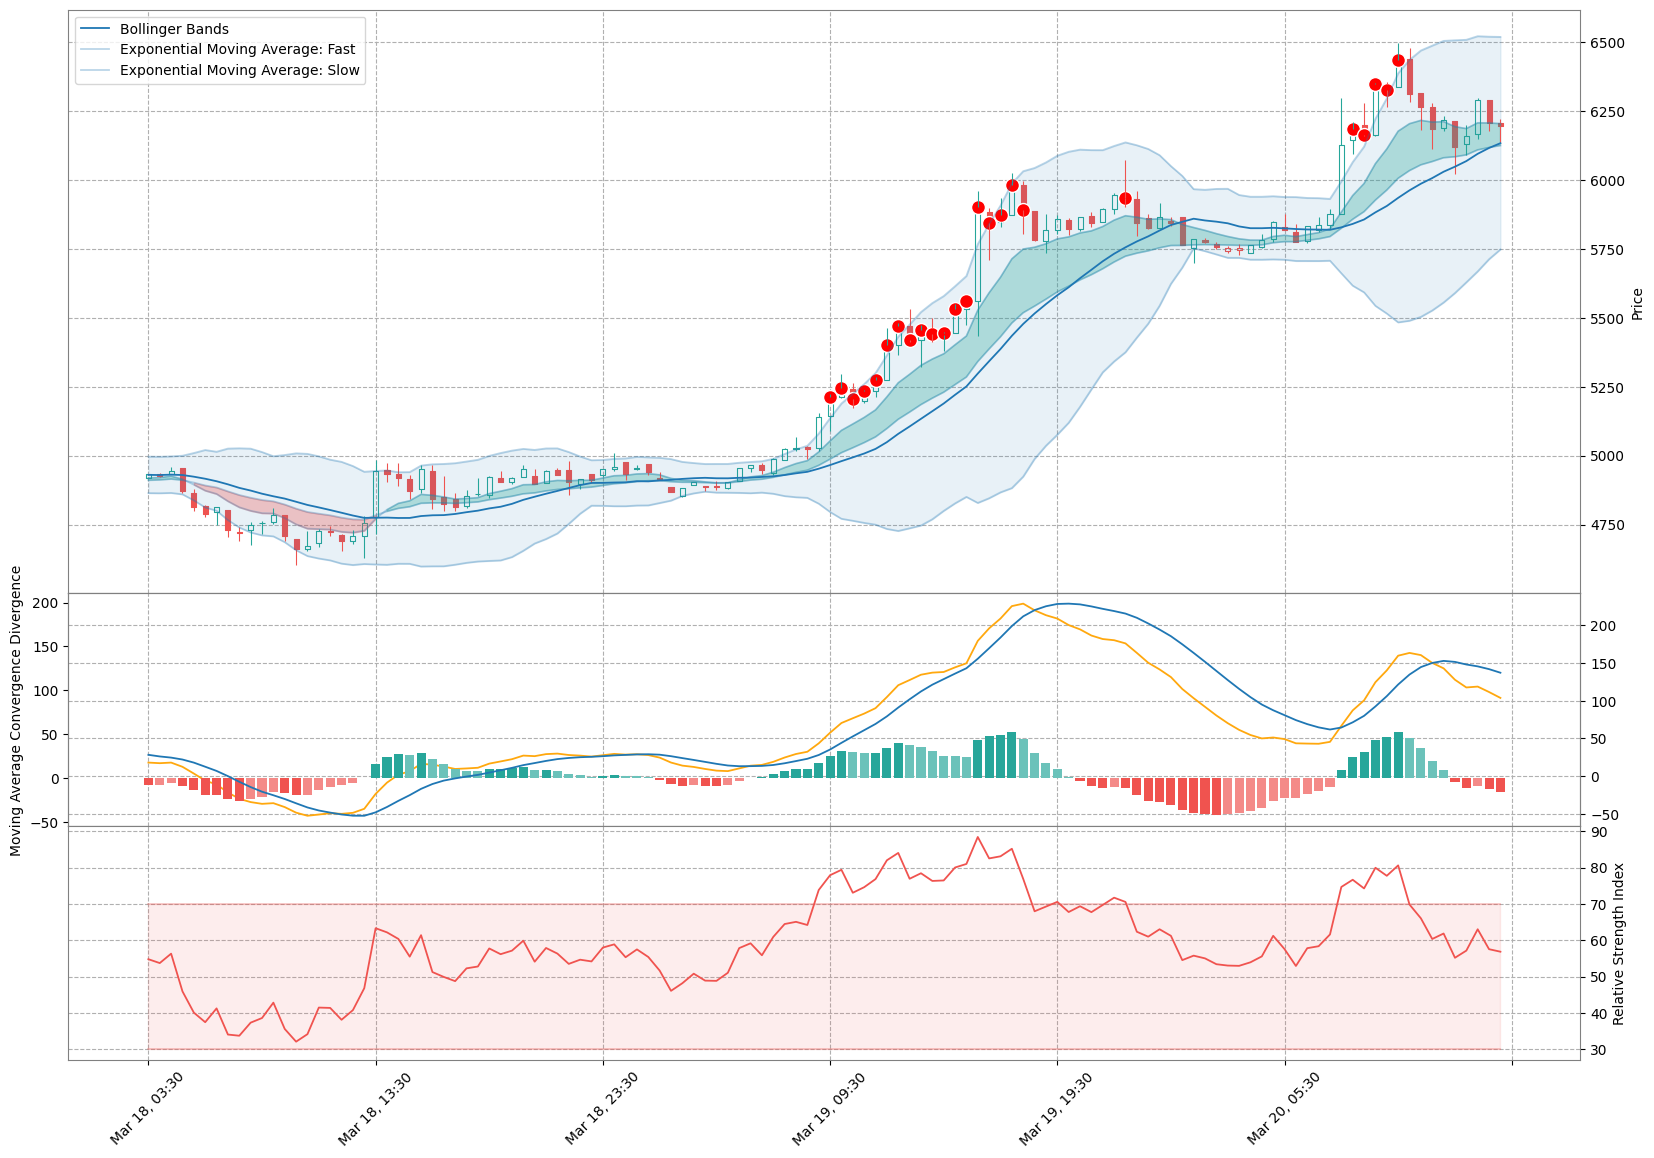

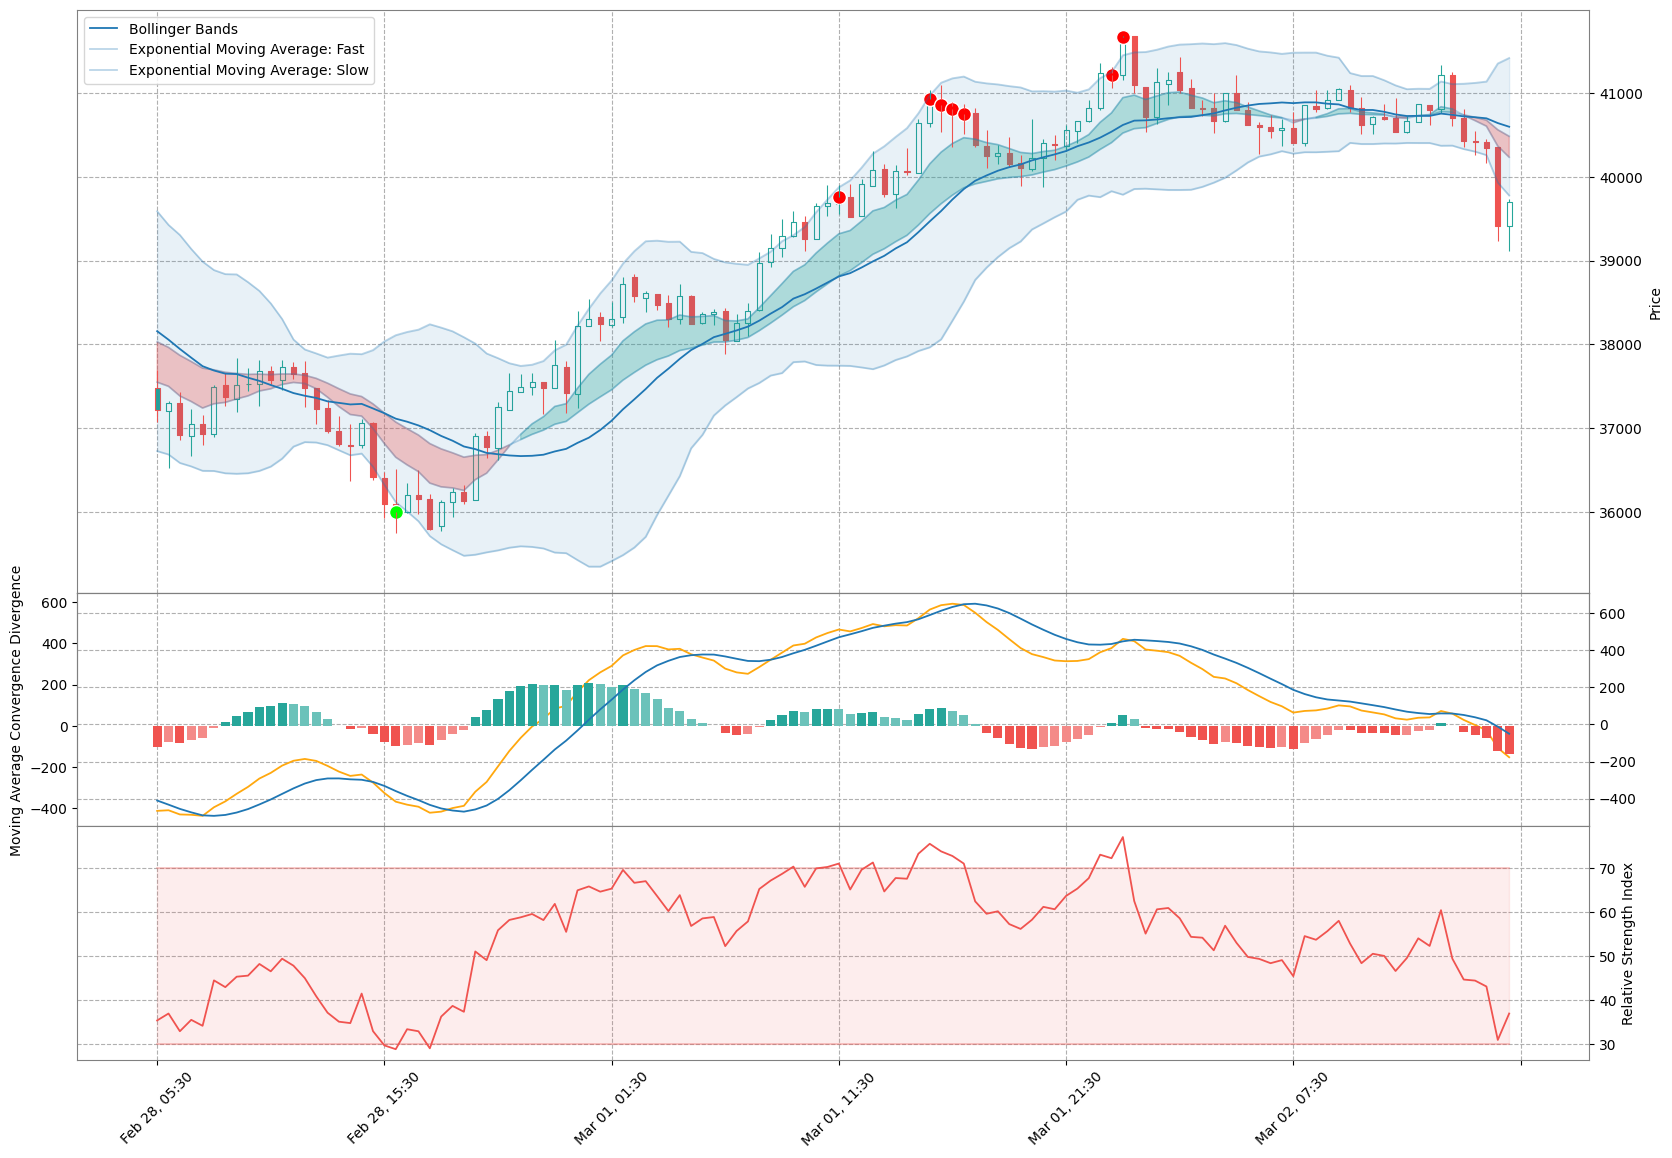

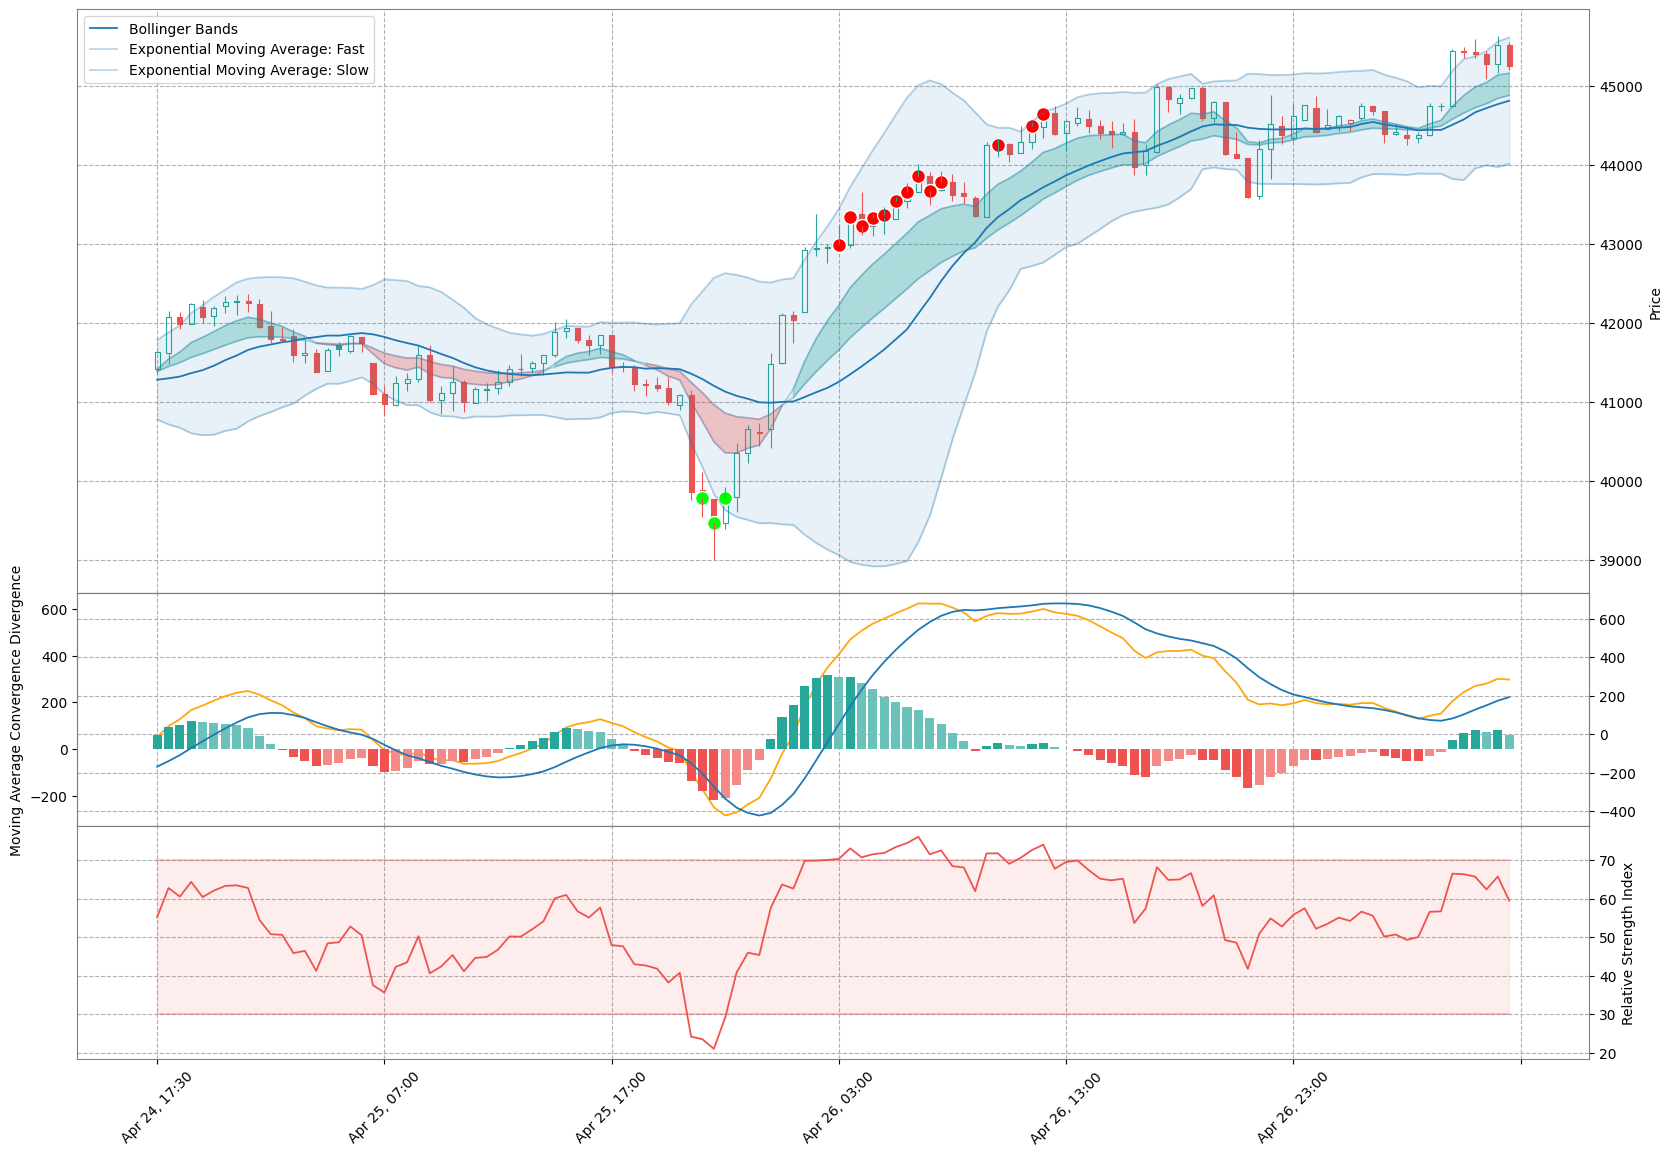

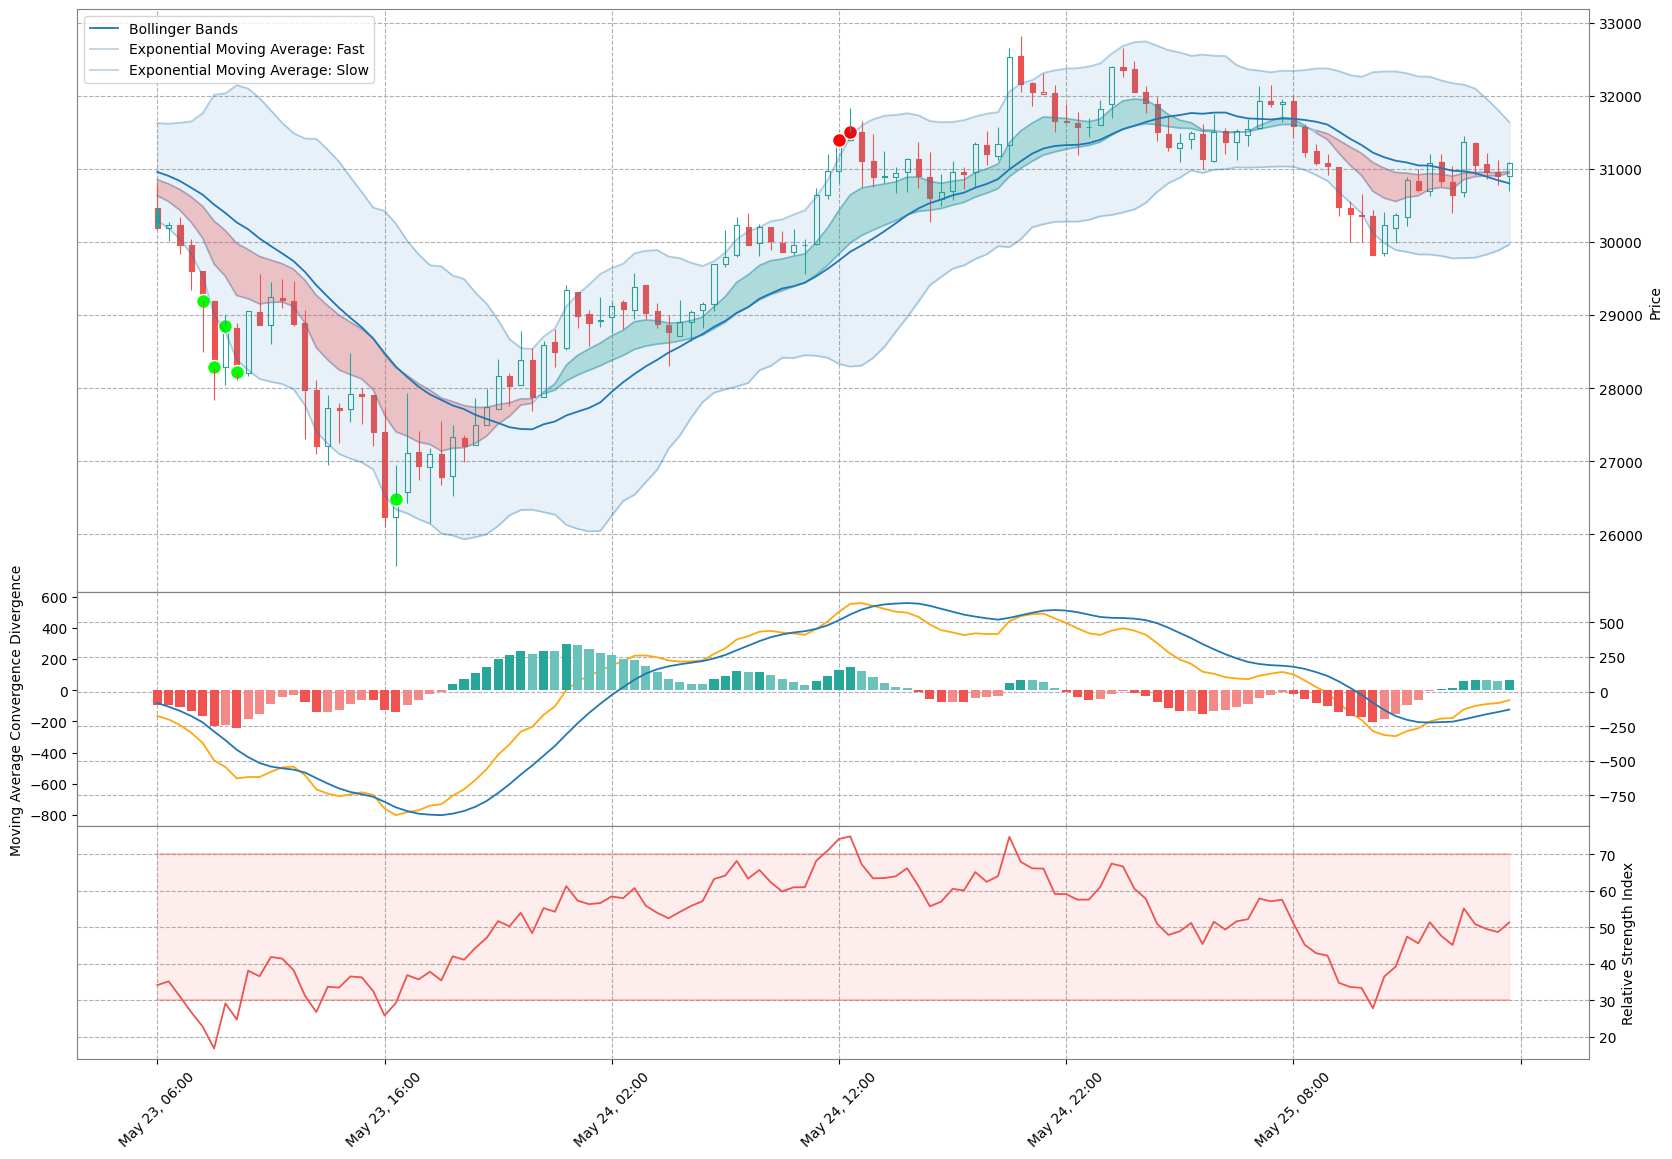

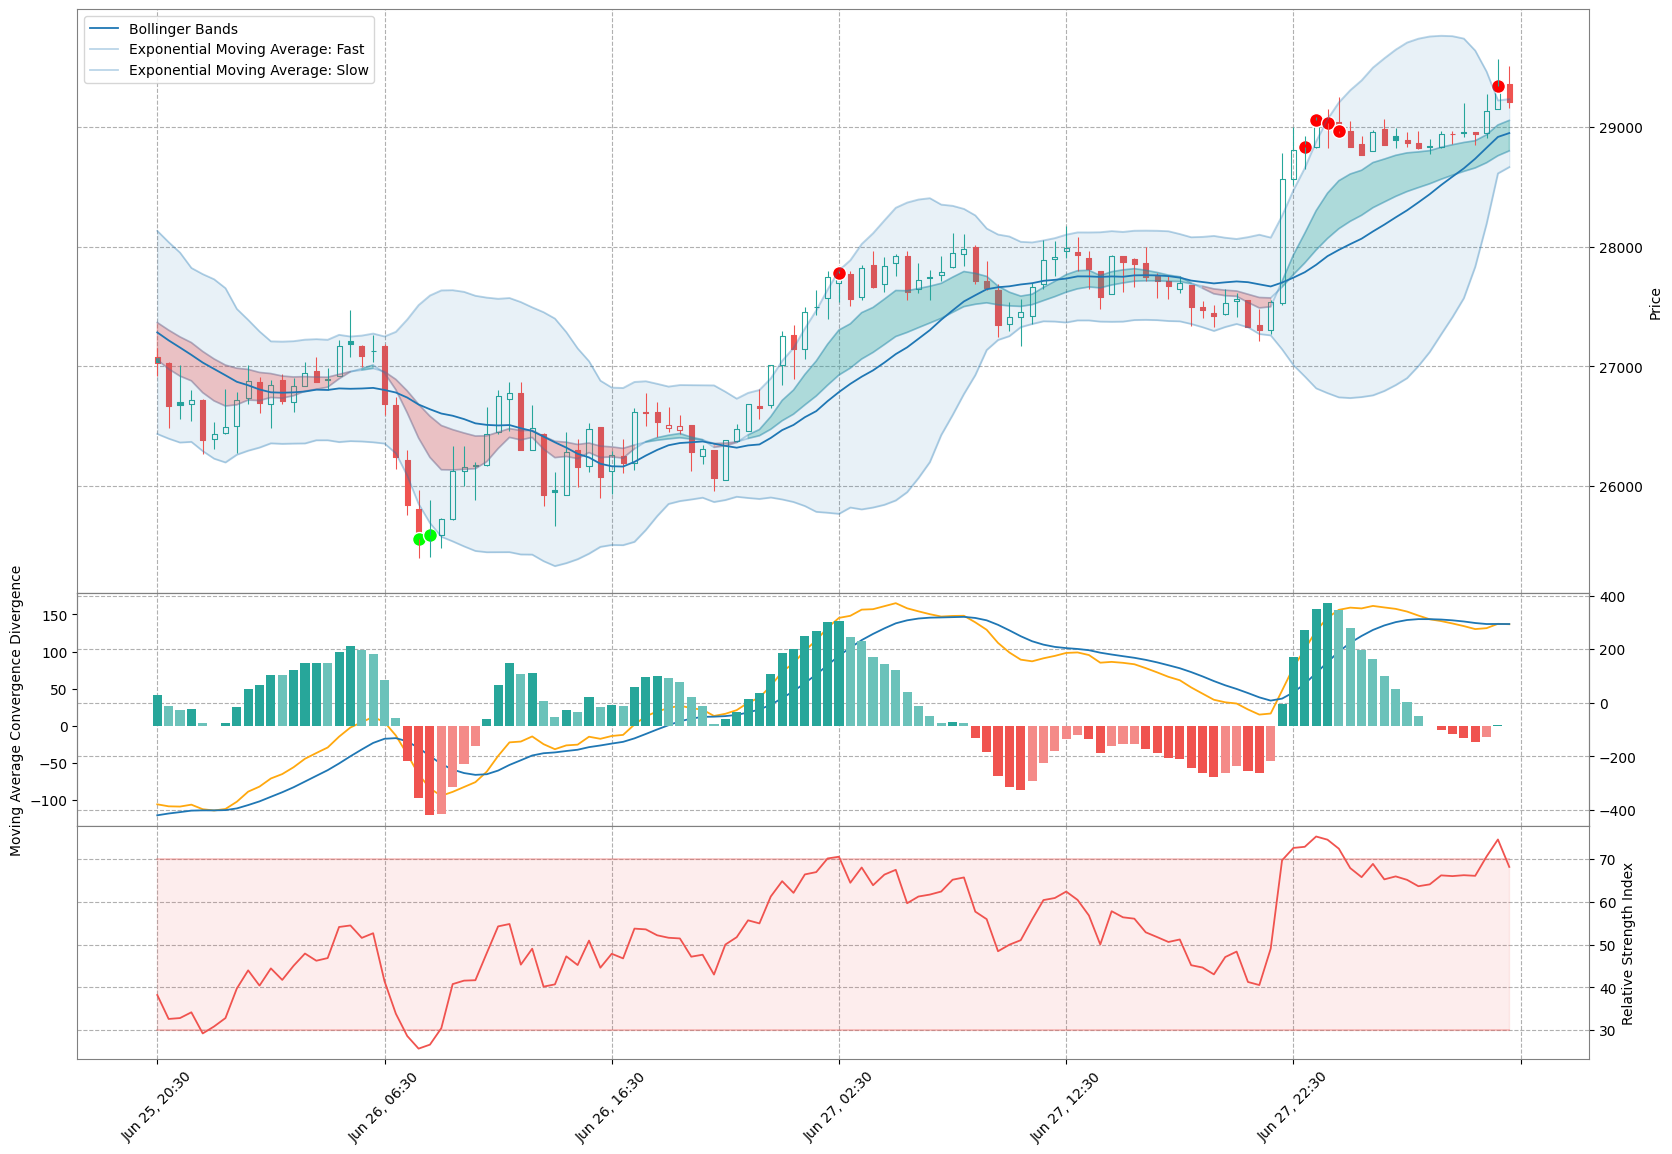

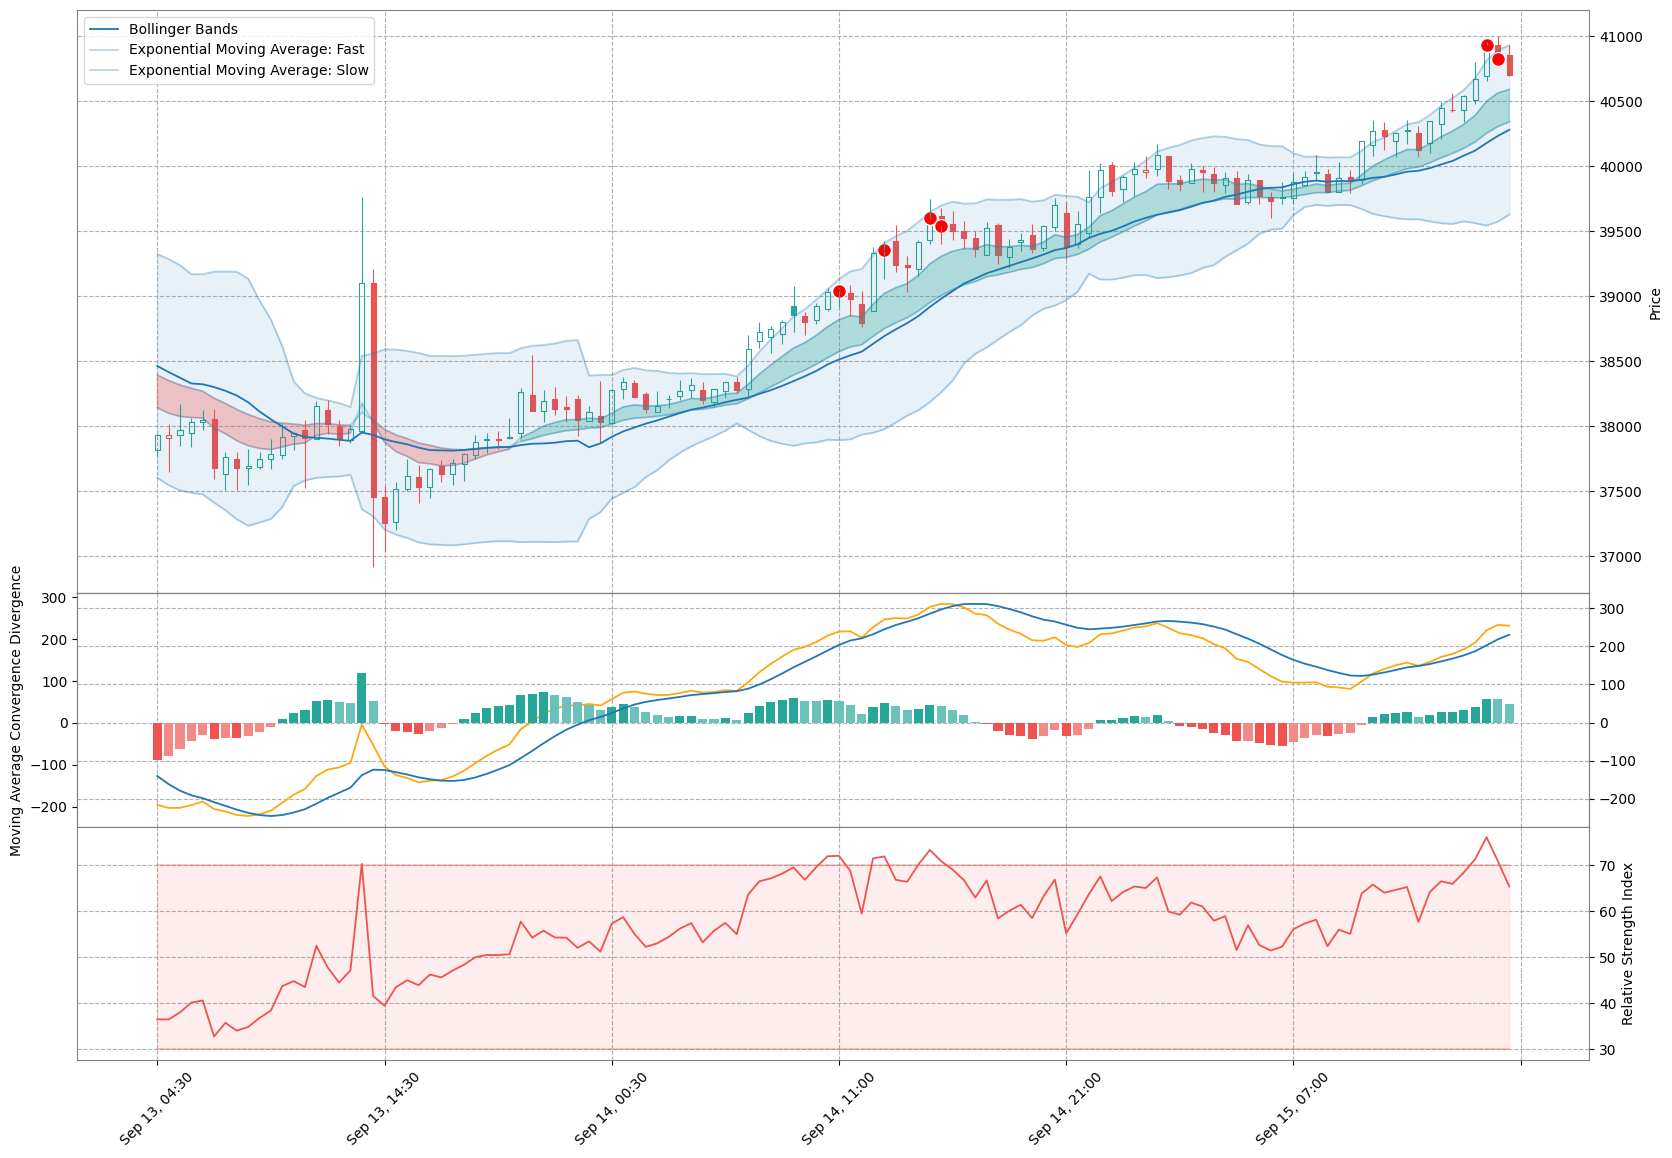

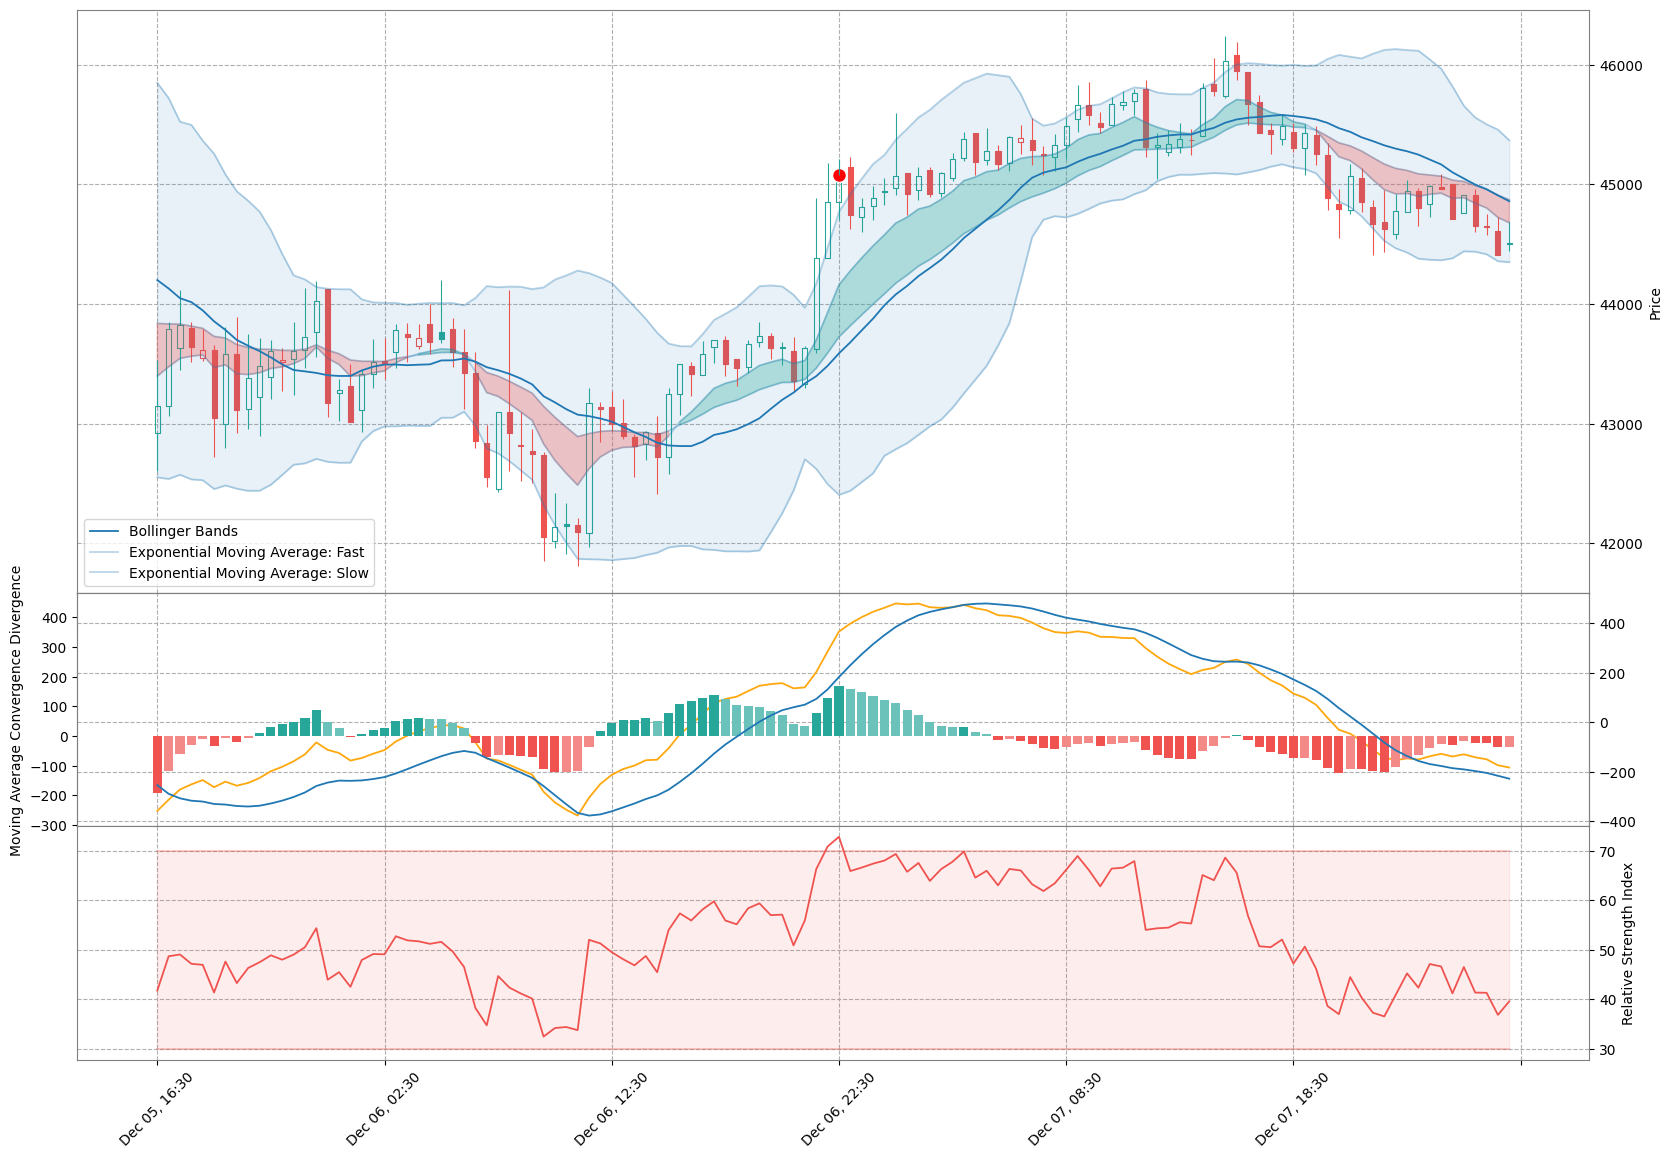

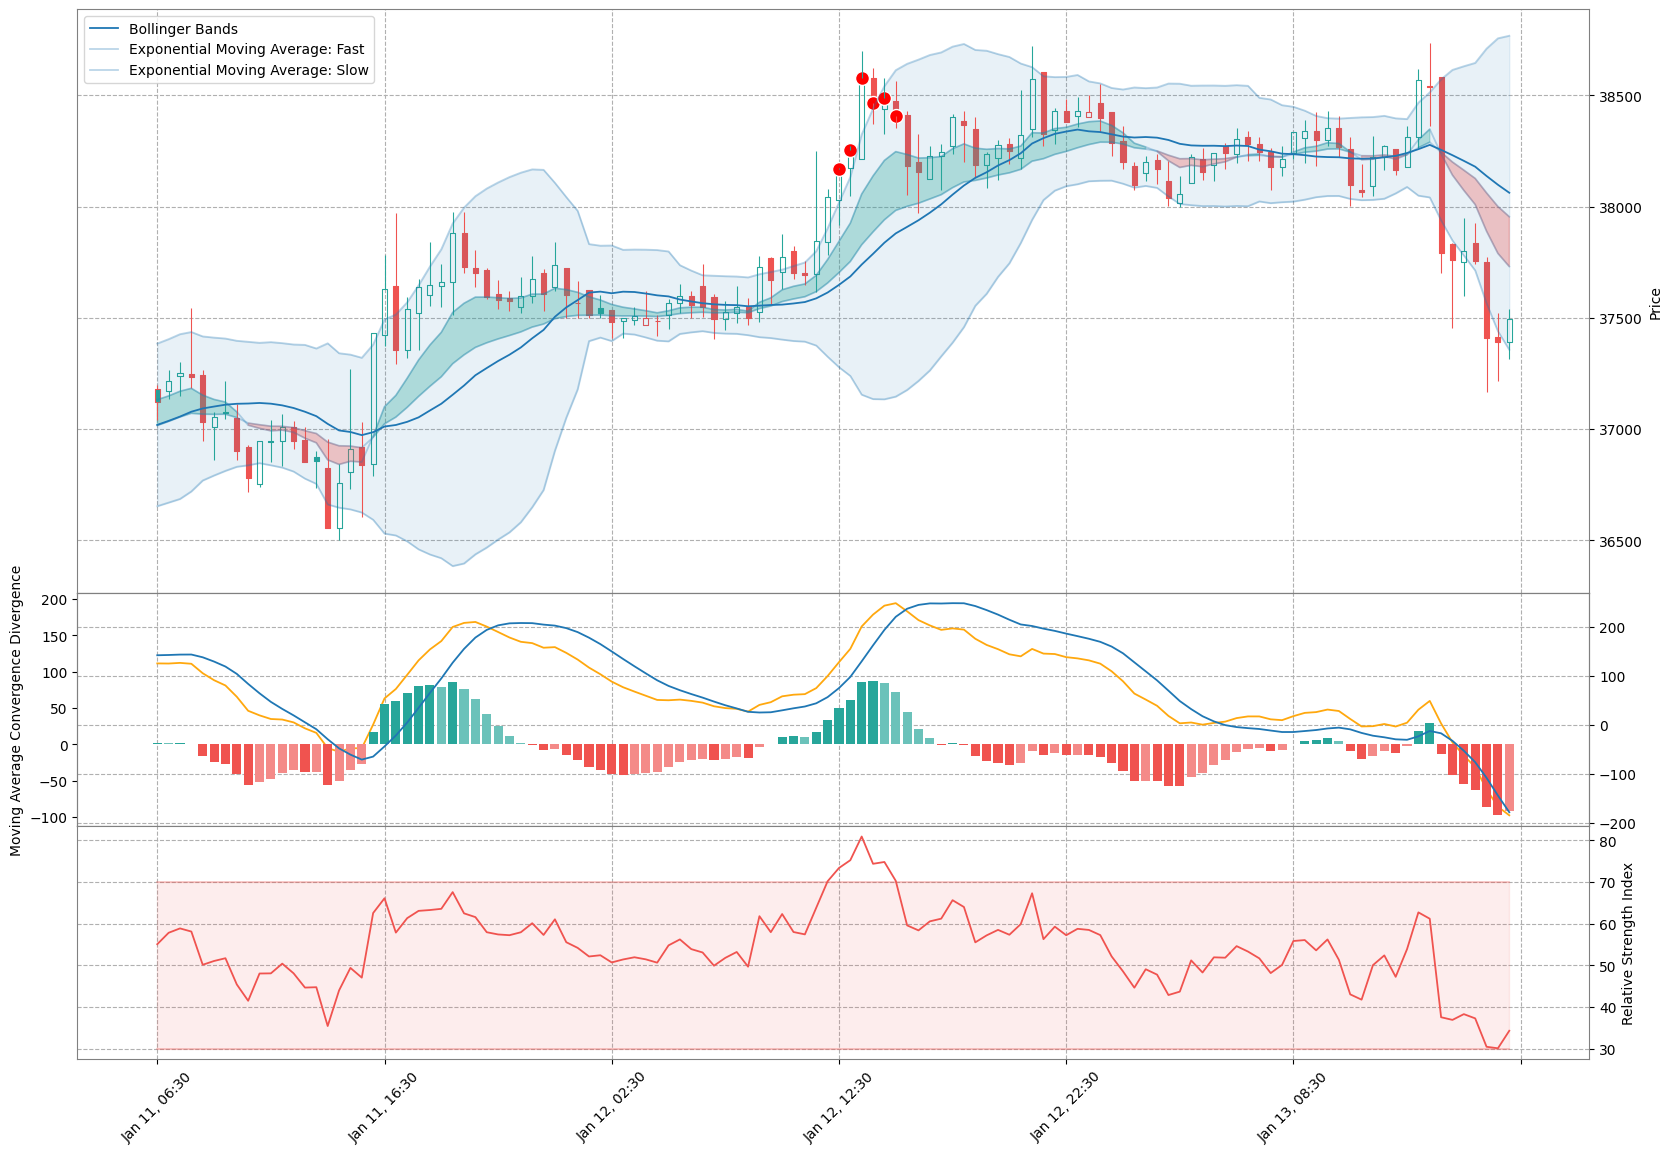

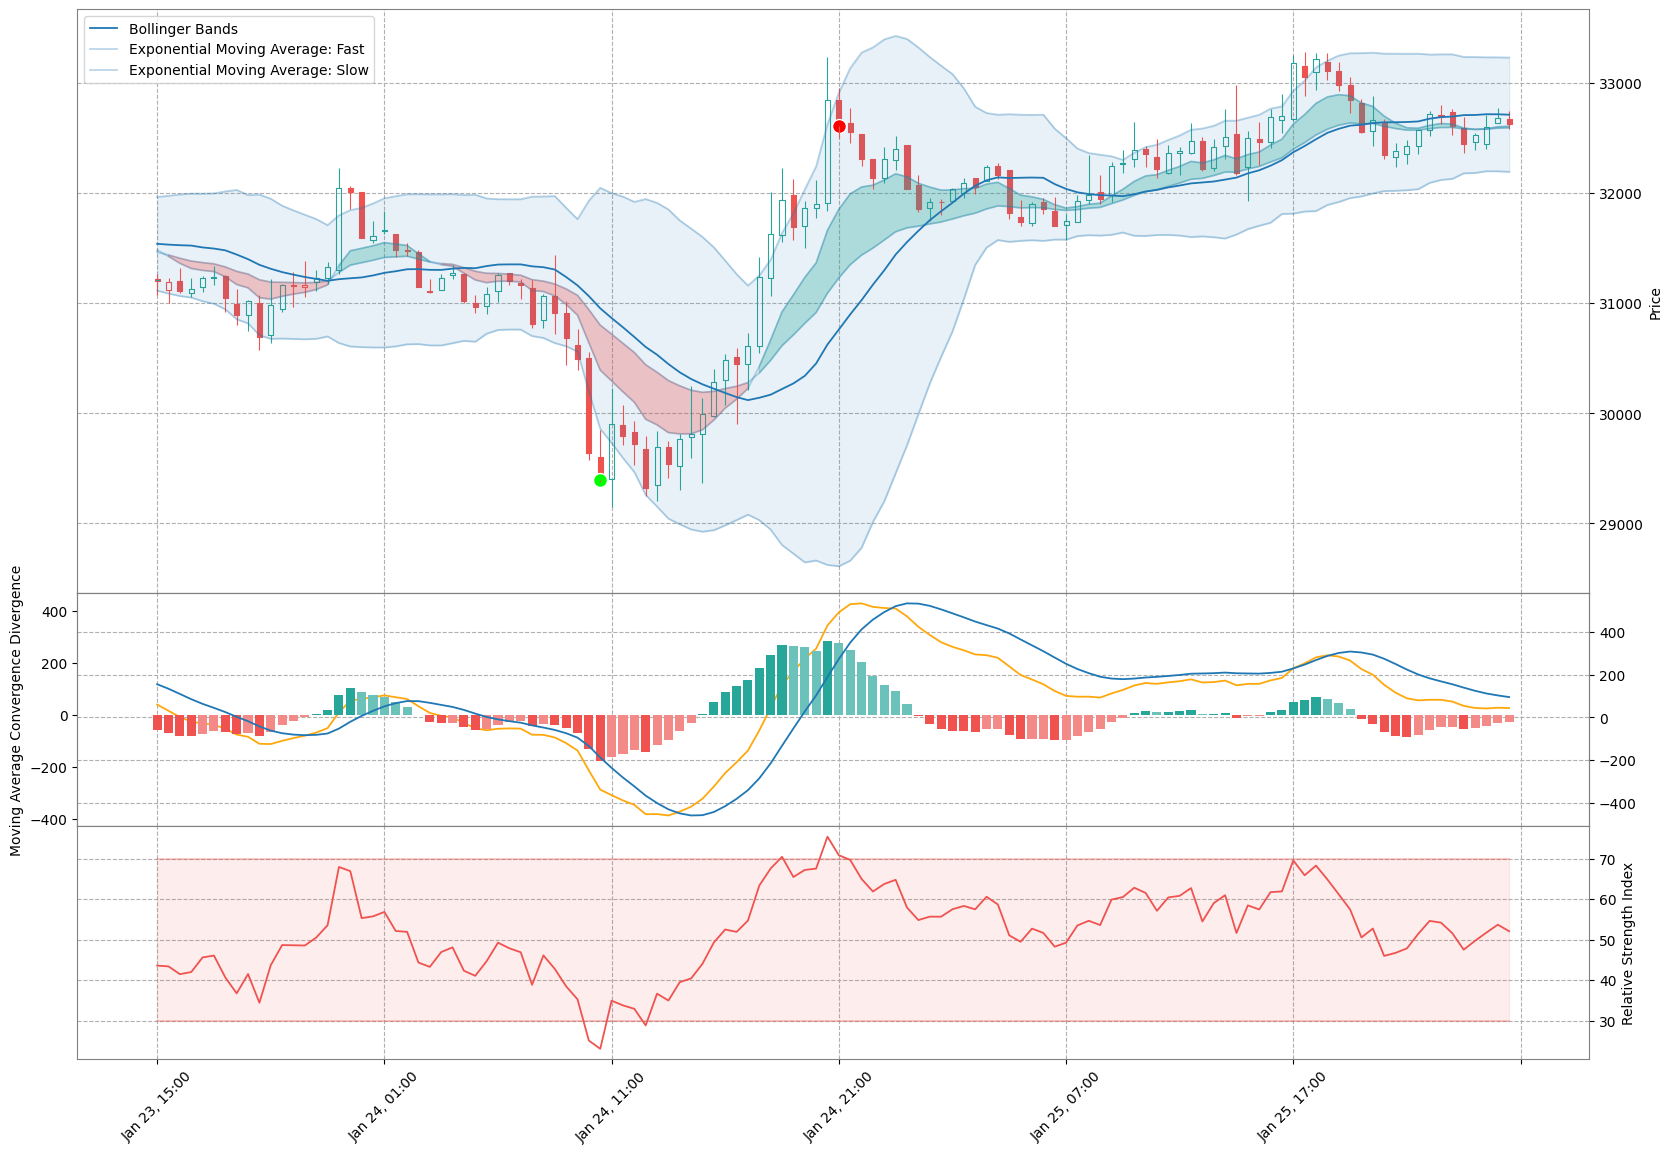

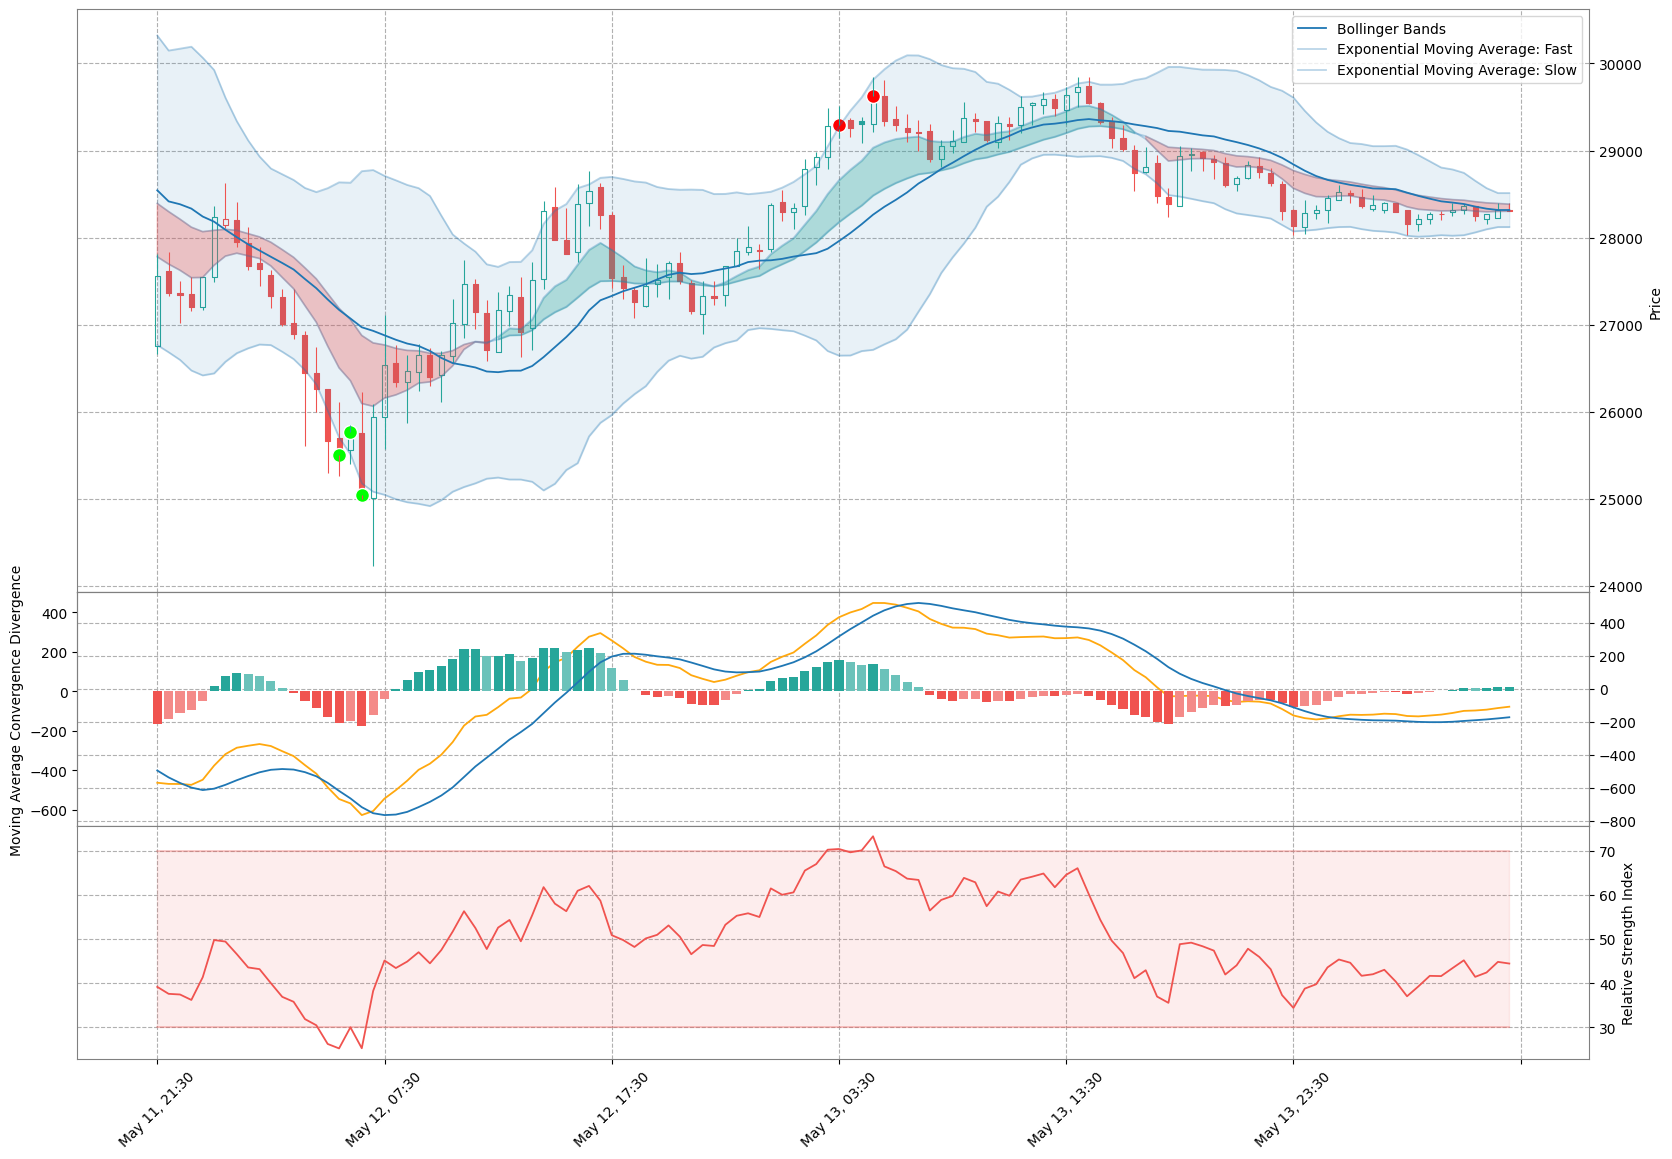

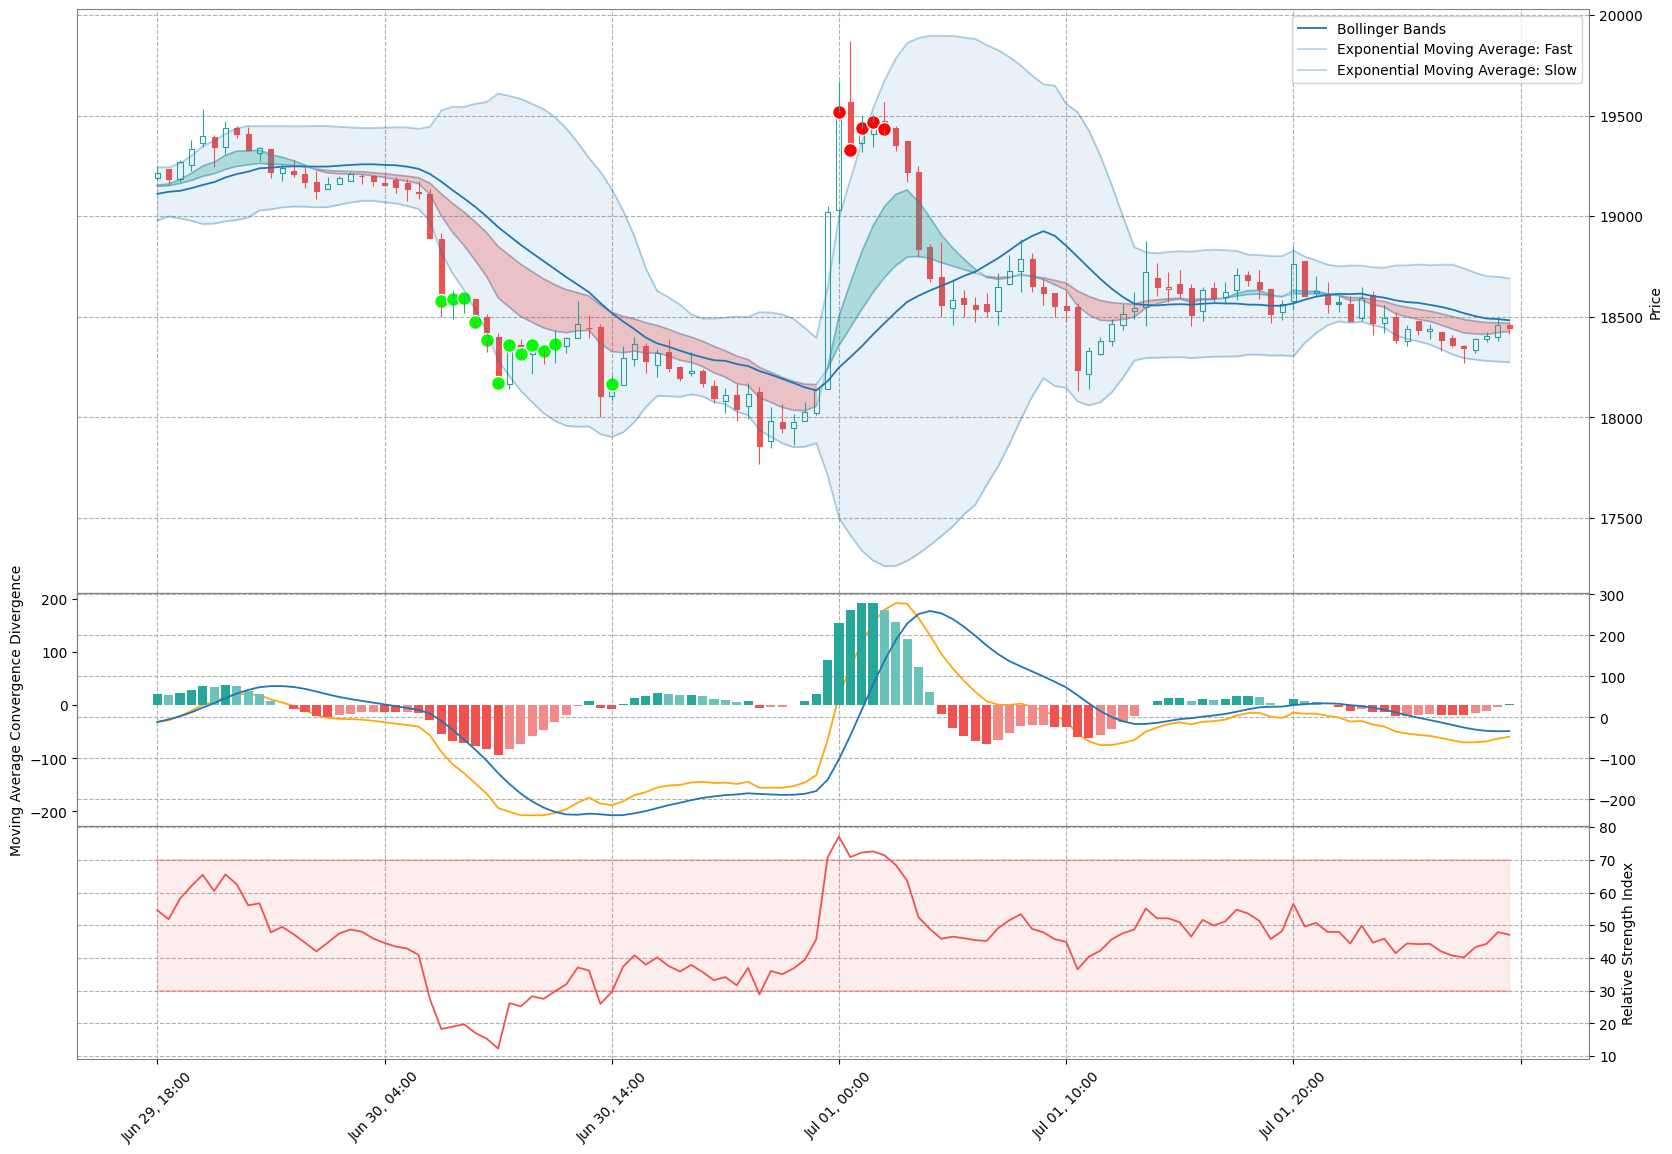

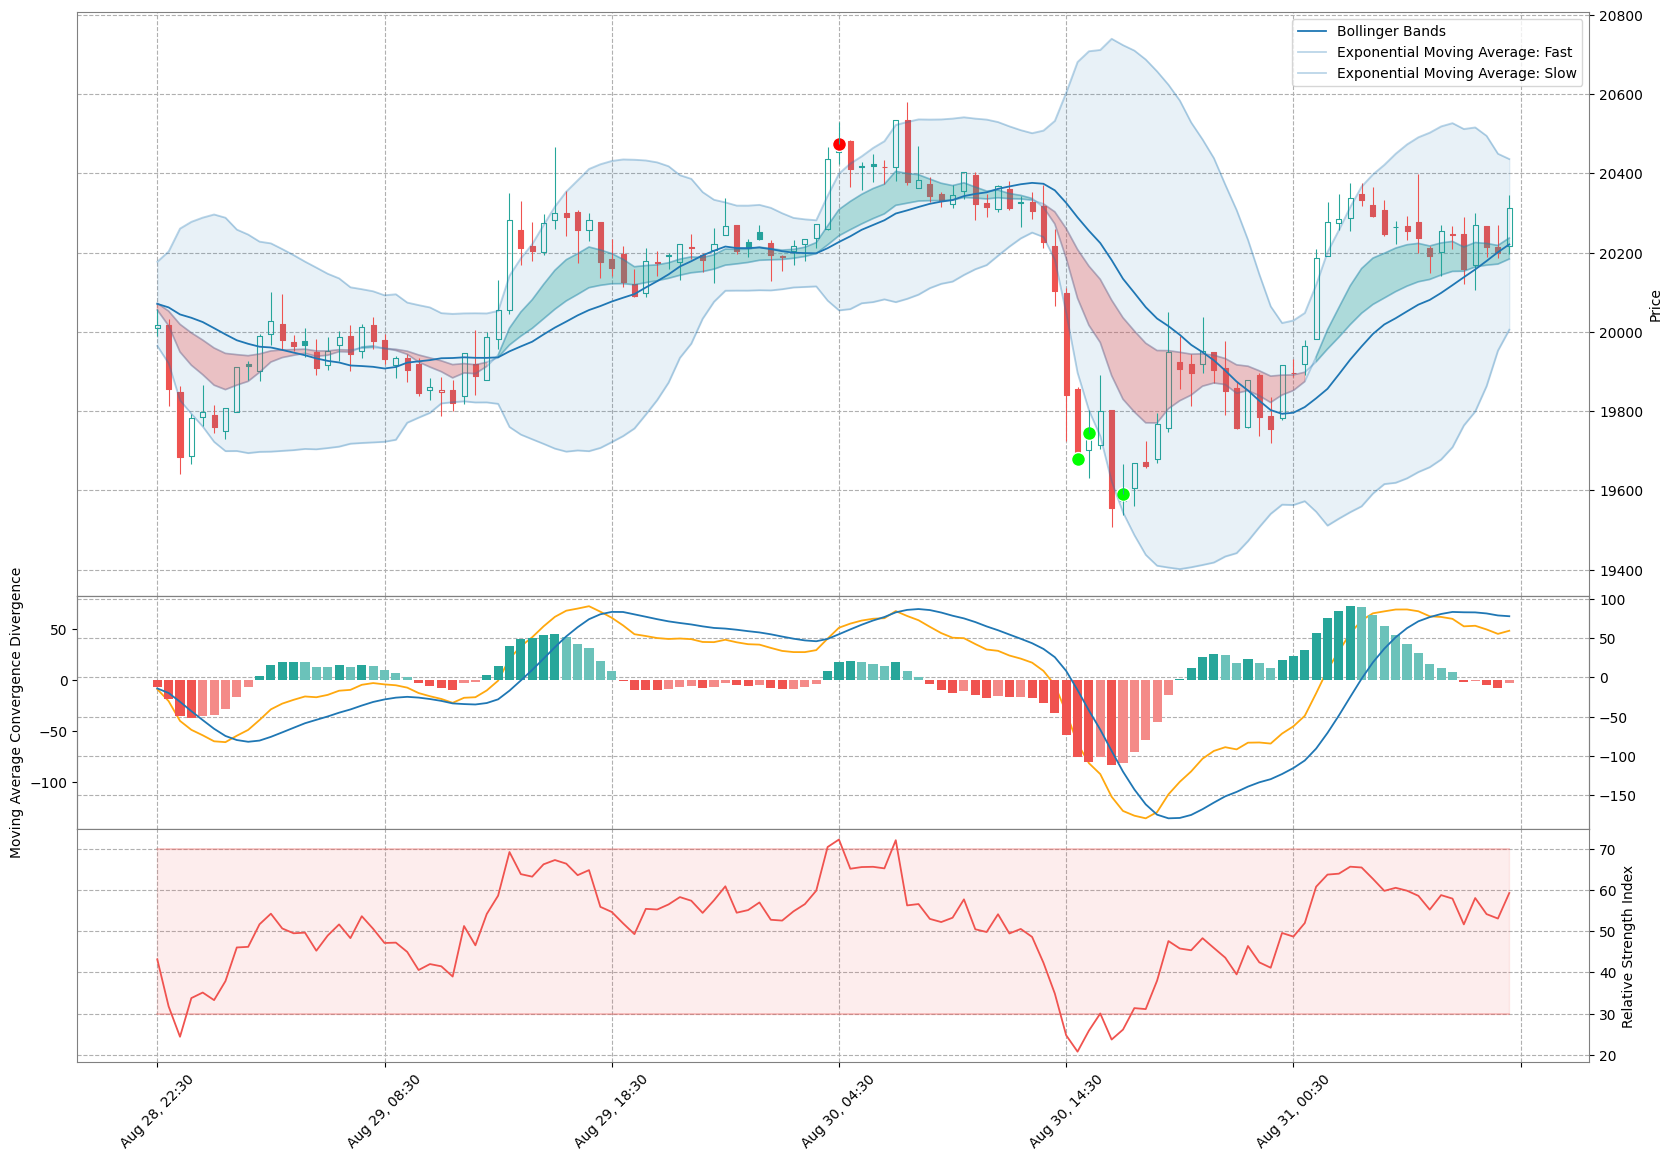

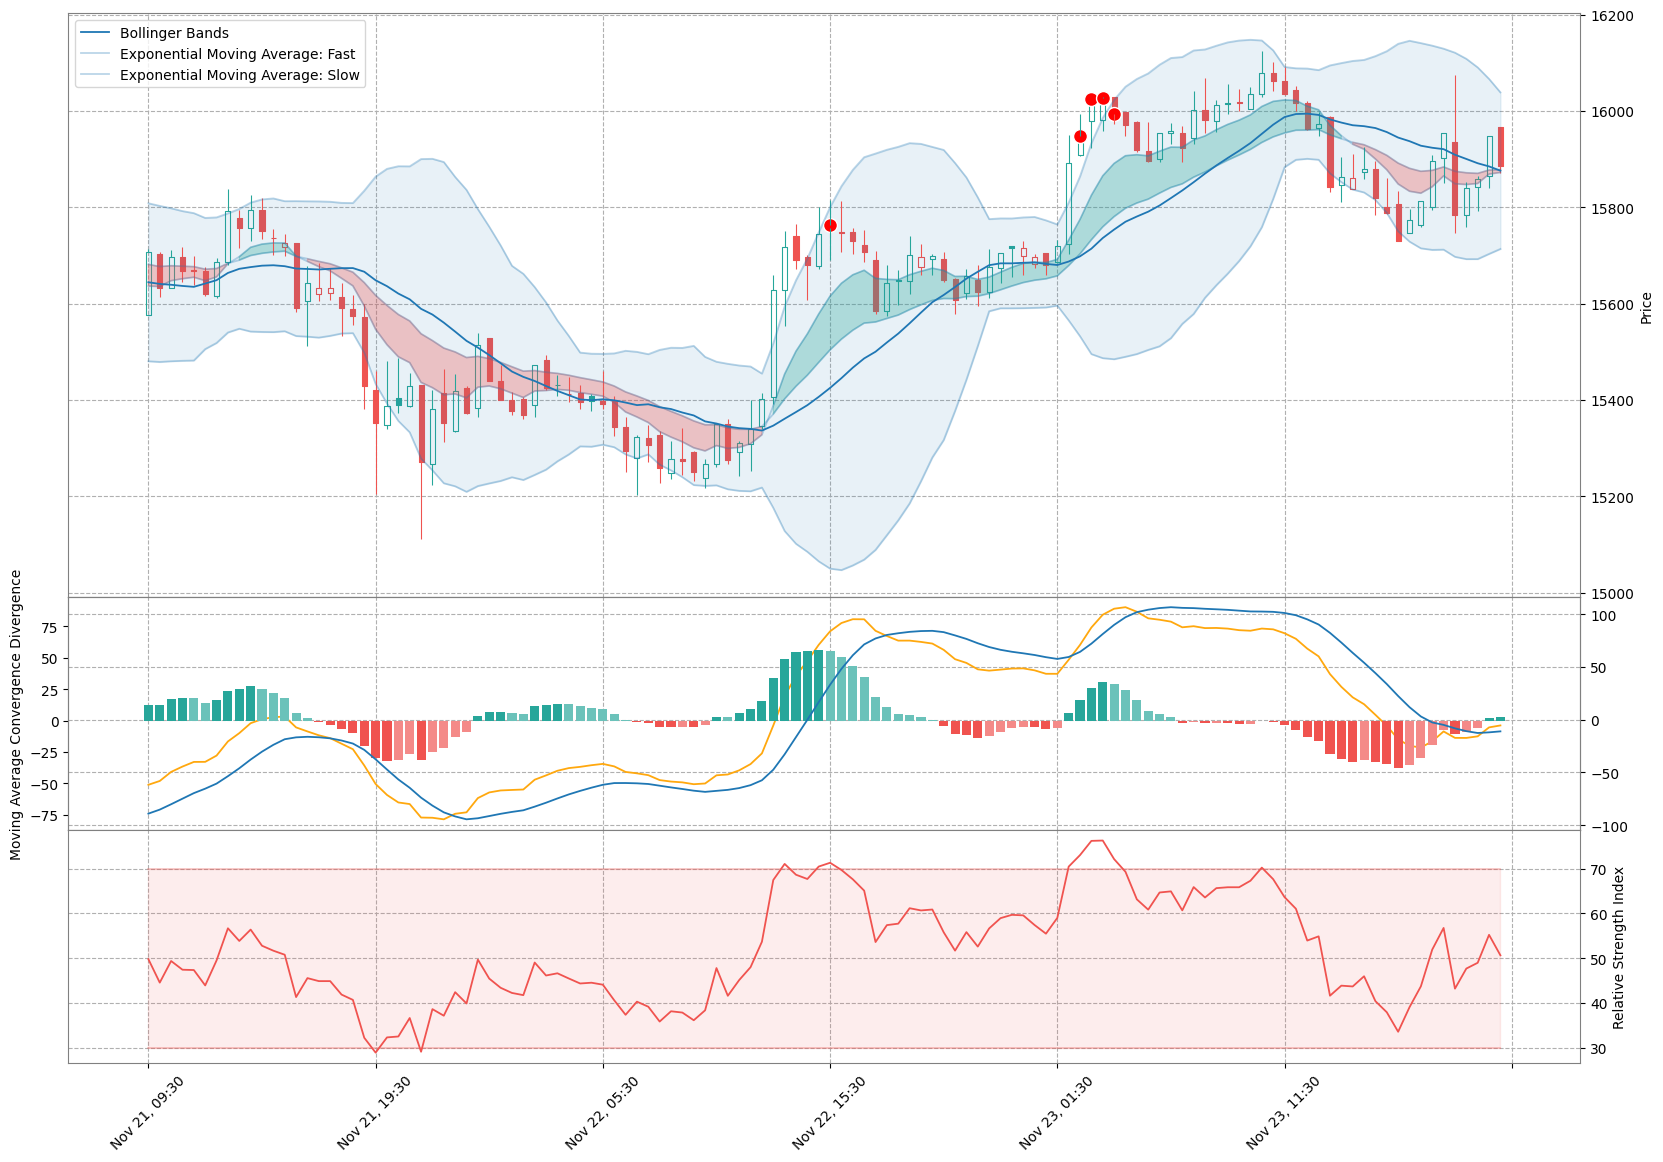

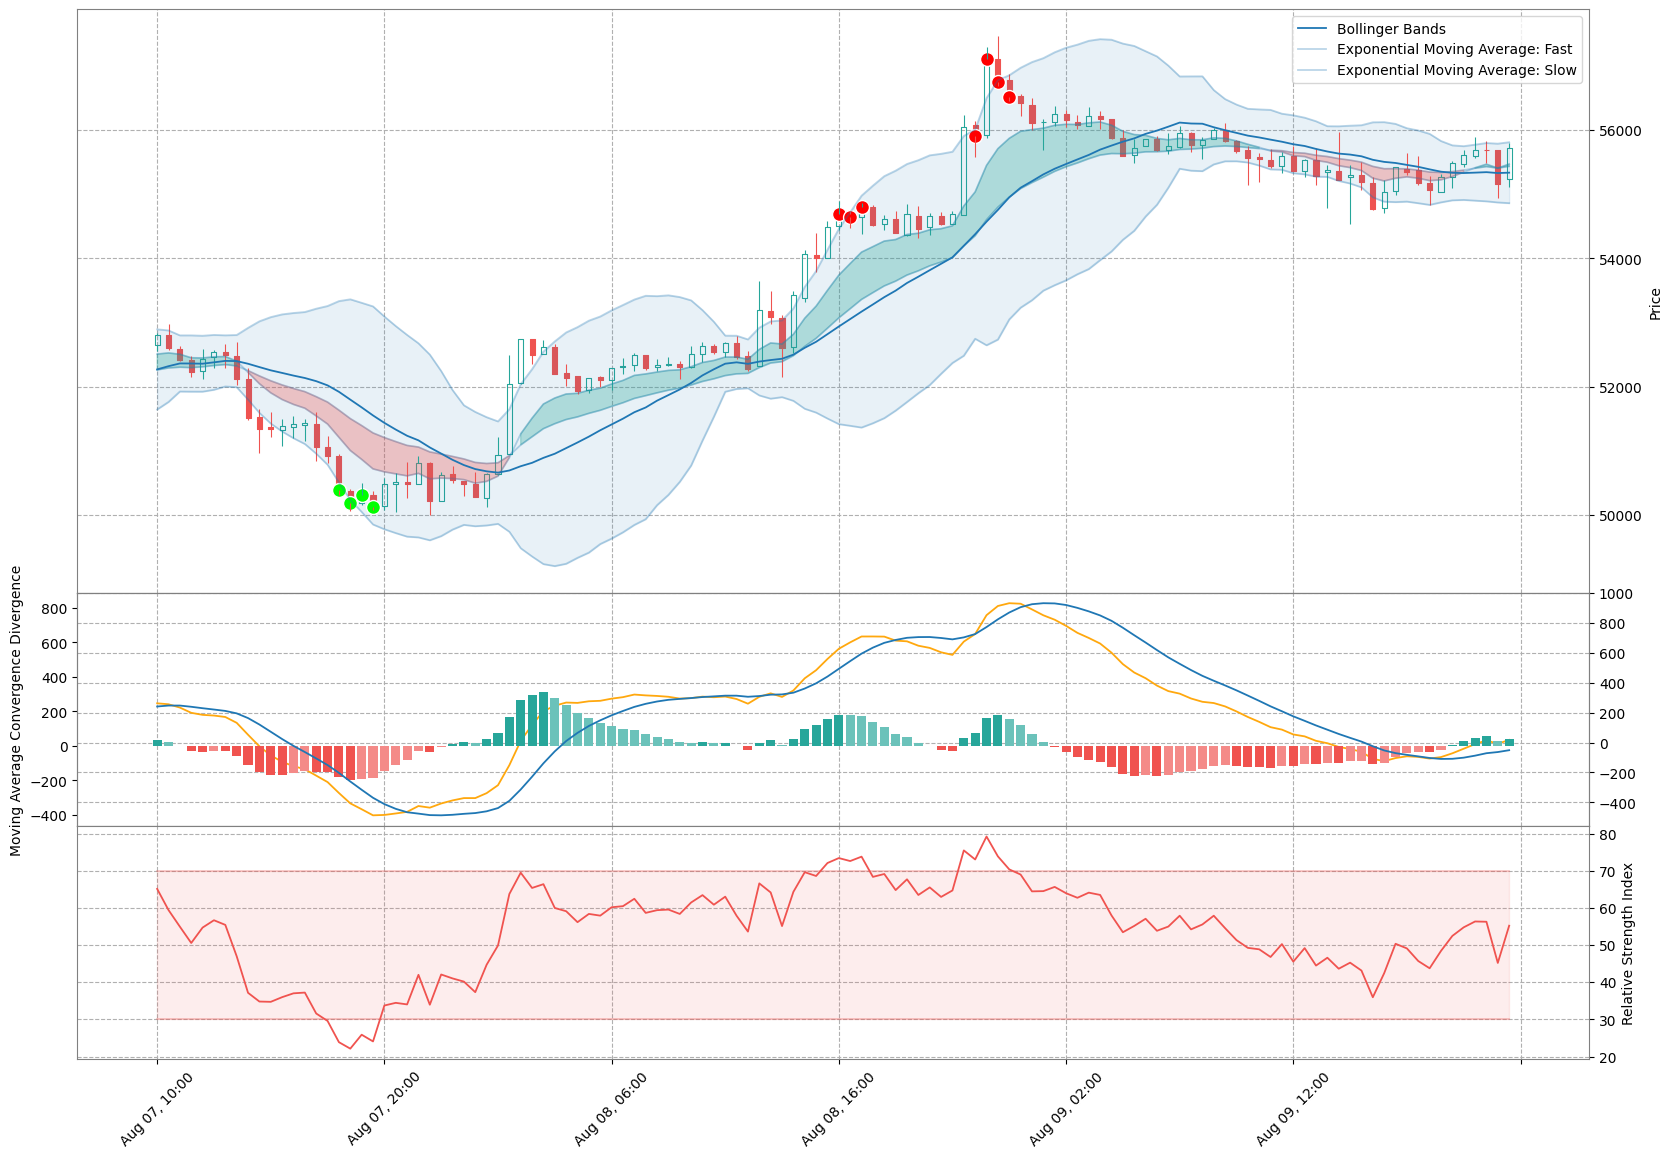

In [11]:
# List all losses of more than 10%
significant_losses = sells.filter(sells[fn.PROFIT_LOSS] < -10)
significant_losses = significant_losses.select(fn.TIMESTAMP)

# Generate candlestick chart for each significant loss
for i, row in significant_losses.to_pandas().iterrows():
    candlestick_chart.plot(row[fn.TIMESTAMP])